In [1]:
!pip install pyalex networkx ijson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 3.9 MB/s eta 0:00:00


Loading raw data from papers referencing social resilience

In [2]:
import os
import json
import networkx as nx
import matplotlib.pyplot as plt
import pyalex
import networkx as nx
import matplotlib.pyplot as plt
from pyalex import Works


def load_local_data(seed_path="seed_works.json", ref_path="reference_metadata.json"):
    """
    Loads the seed works and reference metadata JSON from local files.
    """
    with open(seed_path, "r", encoding="utf-8") as f:
        seed_works = json.load(f)
    with open(ref_path, "r", encoding="utf-8") as f:
        reference_metadata = json.load(f)
    return seed_works, reference_metadata

In [3]:
import ijson
import pandas as pd
import re
import gc

# File Locations
seed_works_loc = '/kaggle/input/social-resilience-data/seed_works.json'
reference_metadata_loc = '/kaggle/input/social-resilience-data/reference_metadata.json'

# Relevant Keywords (Regex Optimized)
RELEVANT_KEYWORDS = ['resilience']
KEYWORD_PATTERNS = [re.compile(rf"\b{re.escape(keyword)}\b", re.IGNORECASE) for keyword in RELEVANT_KEYWORDS]


def flatten_abstract(abstract_index):
    """
    Flatten OpenAlex 'abstract_inverted_index' into a plain text string.
    Ensures correct word order based on positions.
    """
    if not isinstance(abstract_index, dict):
        return ""

    position_word_map = []

    for word, positions in abstract_index.items():
        for position in positions:
            position_word_map.append((position, word))

    # Sort by position index
    position_word_map.sort()

    # Extract words in correct order
    return " ".join(word for _, word in position_word_map)


def is_paper_relevant(title, abstract, topics):
    """
    Validate if a paper is related to 'social resilience'
    based on title, abstract, and topics.
    """
    text_fields = " ".join(filter(None, [title, abstract] + topics)).lower()
    
    # Check for any keyword match
    return any(pattern.search(text_fields) for pattern in KEYWORD_PATTERNS)


def process_json_stream(file_path, source):
    """
    Efficiently loads and filters relevant JSON data using ijson streaming.
    Extracts author and institution information.
    """
    validated_papers = []
    unique_ids = set()
    with open(file_path, "r", encoding="utf-8") as f:
        objects = ijson.items(f, "item")  # Streams JSON array elements
        for obj in objects:
            paper_id = obj.get("id")
            if paper_id in unique_ids:
                continue  # Skip duplicates

            year = obj.get("publication_year", "")
            # Skip papers from 2025
            if year == 2025:
                continue
            
            title = obj.get("title", "")
            abstract = flatten_abstract(obj.get("abstract_inverted_index", {}))
            topics = [c.get("display_name", "") for c in obj.get("topics", [])]
            refs = obj.get("referenced_works", [])
            citations = obj.get("cited_by_count")
            
            # Extract author and institution information
            authors_data = []
            for authorship in obj.get("authorships", []):
                author_info = authorship.get("author", {})
                author_data = {
                    "author_id": author_info.get("id"),
                    "author_name": author_info.get("display_name"),
                    "author_orcid": author_info.get("orcid"),
                    "author_position": authorship.get("author_position"),
                    "institutions": []
                }
                
                # Extract institution information for this author
                for institution in authorship.get("institutions", []):
                    inst_data = {
                        "institution_id": institution.get("id"),
                        "institution_name": institution.get("display_name"),
                        "institution_ror": institution.get("ror"),
                        "country_code": institution.get("country_code"),
                        "institution_type": institution.get("type")
                    }
                    author_data["institutions"].append(inst_data)
                
                authors_data.append(author_data)
            
            if is_paper_relevant(title, abstract, topics):
                validated_papers.append({
                    "id": paper_id,
                    "title": title,
                    "publication_year": year,
                    "abstract": abstract,
                    "topics": topics,
                    "referenced_works": refs,
                    "authors": authors_data,  # Added authors data
                    "citation_count": citations,
                    "source": source
                })
                unique_ids.add(paper_id)
            # Periodically free memory
            if len(validated_papers) >= 5000:
                yield validated_papers
                validated_papers = []
                gc.collect()
    # Return remaining batch
    if validated_papers:
        yield validated_papers
        gc.collect()


# ------------------------------------------------------------
# 1. Validate Papers from Seed Works
# ------------------------------------------------------------
validated_papers = []
for batch in process_json_stream(seed_works_loc, source="seed"):
    validated_papers.extend(batch)

print(f"Validated {len(validated_papers)} unique papers from seed works.")

# ------------------------------------------------------------
# 2. Validate Papers from Reference Metadata
# ------------------------------------------------------------
for batch in process_json_stream(reference_metadata_loc, source="reference"):
    validated_papers.extend(batch)

print(f"Validated {len(validated_papers)} unique papers in total (including references).")

# ------------------------------------------------------------
# 3. Convert to DataFrame and Deduplicate
# ------------------------------------------------------------
validated_df = pd.DataFrame(validated_papers)

# Final Deduplication
before_dedup = len(validated_df)
validated_df.drop_duplicates(subset="id", keep="first", inplace=True)
after_dedup = len(validated_df)

print(f"Removed {before_dedup - after_dedup} duplicate entries during final deduplication.")

# Save to CSV
validated_df.to_csv('validated_social_resilience_papers.csv', index=False)
print("Validated papers saved to 'validated_social_resilience_papers.csv'.")

# Clean Up Memory
del validated_papers
gc.collect()

# ------------------------------------------------------------
# 4. Display Sample of Validated Papers
# ------------------------------------------------------------
validated_df


Validated 16742 unique papers from seed works.
Validated 16742 unique papers in total (including references).
Removed 0 duplicate entries during final deduplication.
Validated papers saved to 'validated_social_resilience_papers.csv'.


,id,title,publication_year,abstract,topics,referenced_works,authors,citation_count,source
0,https://openalex.org/W628234387,The Vulnerability of Cities: Natural Disasters...,2005,When disaster strikes in cities the effects ca...,[Urban and Rural Development Challenges],[],[{'author_id': 'https://openalex.org/A50701360...,1088,seed
1,https://openalex.org/W2274815048,"Resilience, Adaptability and Transformability ...",2004,"Walker, B., C. Holling, S. R. Carpenter and A....",[Land Use and Ecosystem Services],[],[{'author_id': 'https://openalex.org/A50815165...,6549,seed
2,https://openalex.org/W2096522898,Social and ecological resilience: are they rel...,2000,This article defines social resilience as the ...,"[Vietnamese History and Culture Studies, Clima...","[https://openalex.org/W1165548425, https://ope...",[{'author_id': 'https://openalex.org/A50000891...,4324,seed
3,https://openalex.org/W2084530896,Resilience: The emergence of a perspective for...,2006,,"[Ecosystem dynamics and resilience, Land Use a...","[https://openalex.org/W115314074, https://open...",[{'author_id': 'https://openalex.org/A50370951...,6549,seed
4,https://openalex.org/W2328368677,What is social resilience? Lessons learned and...,2013,"Over the last decade, a growing body of litera...","[Disaster Management and Resilience, Resilienc...","[https://openalex.org/W1493310487, https://ope...",[{'author_id': 'https://openalex.org/A50118357...,655,seed
...,...,...,...,...,...,...,...,...,...
16737,https://openalex.org/W252959653,Locations of remorse and homelands of resilien...,1999,,[Intergenerational Family Dynamics and Caregiv...,"[https://openalex.org/W101969789, https://open...",[{'author_id': 'https://openalex.org/A50755983...,38,seed
16738,https://openalex.org/W3128215380,Fairy circles reveal the resilience of self-or...,2021,Self-organized fairy circles reveal the resili...,"[Ecosystem dynamics and resilience, Earth Syst...","[https://openalex.org/W1951661599, https://ope...",[{'author_id': 'https://openalex.org/A50424349...,52,seed
16739,https://openalex.org/W2806214250,Business analytics leveraging resilience in or...,2018,Purpose The survival and growth of organizatio...,"[Supply Chain Resilience and Risk Management, ...","[https://openalex.org/W1268277, https://openal...",[{'author_id': 'https://openalex.org/A50376553...,37,seed
16740,https://openalex.org/W1993595410,The role of collective symbols as enhancing re...,2011,,"[Children's Rights and Participation, Art Ther...","[https://openalex.org/W1003080678, https://ope...",[{'author_id': 'https://openalex.org/A50122643...,30,seed


Separating 

In [4]:
authors_df = validated_df.copy()
validated_df = validated_df.drop(columns=['authors'])
authors_df = authors_df.drop(columns=['referenced_works'])

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import ast

def build_citation_network(validated_df):
    """
    Build a directed citation network using:
      - validated_df: DataFrame containing all validated papers (both seed and references)
    """
    G = nx.DiGraph()

    # Map paper IDs to metadata (for quick lookup)
    paper_metadata = validated_df.set_index("id").to_dict(orient="index")

    for paper_id, paper_data in paper_metadata.items():
        title = paper_data.get("title", "N/A")
        year = paper_data.get("year", None)
        
        G.add_node(paper_id, title=title, year=year)

        # Parse referenced works safely
        refs = paper_data.get("referenced_works", [])
        if isinstance(refs, str):
            refs = ast.literal_eval(refs)  # Convert string to list if needed
        
        if isinstance(refs, list):
            for ref_id in refs:
                if ref_id in paper_metadata:  # Only include valid references
                    ref_data = paper_metadata[ref_id]
                    ref_title = ref_data.get("title", "N/A")
                    ref_year = ref_data.get("year", None)

                    G.add_node(ref_id, title=ref_title, year=ref_year)
                    G.add_edge(paper_id, ref_id)

    return G


Columns in dataset: Index(['id', 'title', 'publication_year', 'abstract', 'topics',
       'referenced_works', 'authors', 'citation_count', 'source'],
      dtype='object')

Number of publications per year:
publication_year
1818       1
1932       1
1933       1
1937       2
1946       1
        ... 
2020    1173
2021    1123
2022     833
2023     801
2024     905
Name: count, Length: 63, dtype: int64

Peak Publication Year: 2020 with 1173 papers.


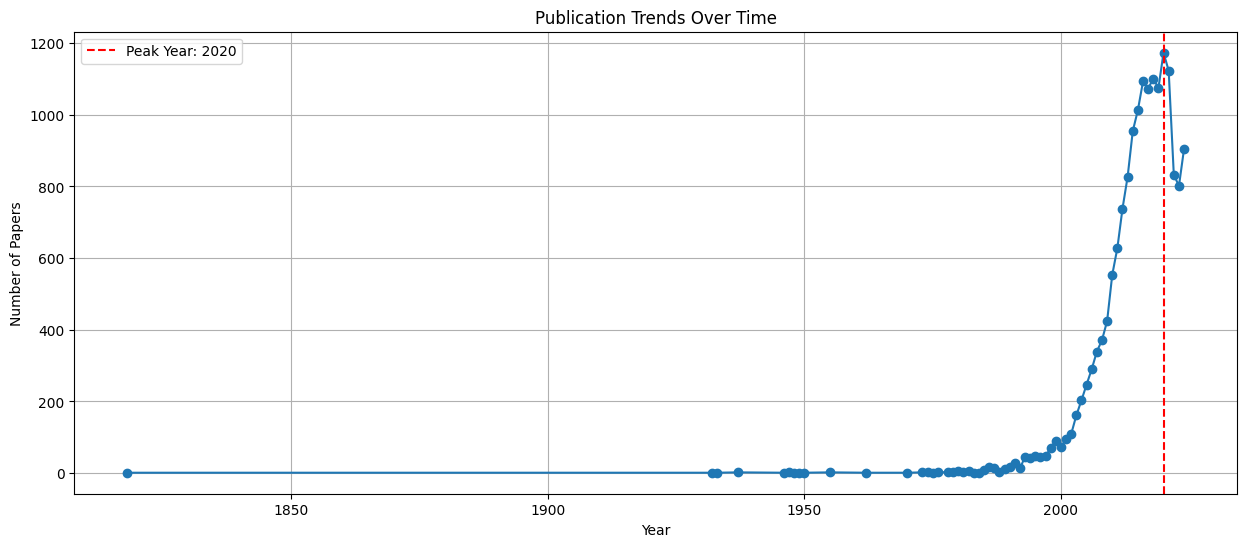

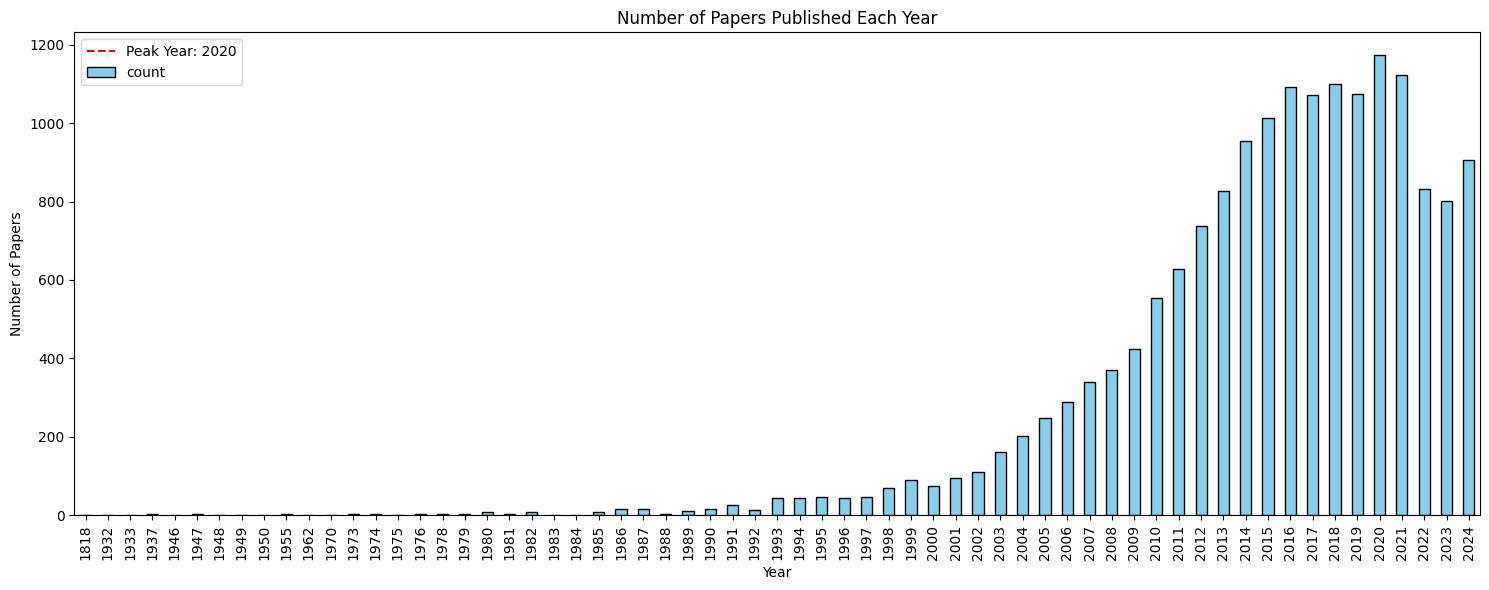

Publication year distribution saved to 'publication_year_distribution.csv'.
CPU times: user 2.43 s, sys: 1 s, total: 3.43 s
Wall time: 2.34 s


In [6]:
%%time
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Load Validated Data
# ------------------------------------------------------------
validated_df = pd.read_csv('validated_social_resilience_papers.csv')
# validated_df = validated_df[validated_df['source'] == 'seed'] ##########################################################################

# Display dataset structure
print("Columns in dataset:", validated_df.columns)

# ------------------------------------------------------------
# 2. Extract and Clean Publication Years
# ------------------------------------------------------------
# Some rows might not have a publication year; handle these gracefully
validated_df['publication_year'] = pd.to_numeric(validated_df['publication_year'], errors='coerce')

# Drop rows without valid years
validated_df = validated_df.dropna(subset=['publication_year'])
validated_df['publication_year'] = validated_df['publication_year'].astype(int)

# ------------------------------------------------------------
# 3. Analyze Publication Year Distribution
# ------------------------------------------------------------
year_counts = validated_df['publication_year'].value_counts().sort_index()
print("\nNumber of publications per year:")
print(year_counts)

# Identify the year with the highest number of publications
peak_year = year_counts.idxmax()
peak_count = year_counts.max()
print(f"\nPeak Publication Year: {peak_year} with {peak_count} papers.")

# ------------------------------------------------------------
# 4. Visualize Publication Year Trends
# ------------------------------------------------------------
plt.figure(figsize=(15, 6))
plt.plot(year_counts.index, year_counts.values, marker='o', linestyle='-')
plt.title('Publication Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.axvline(peak_year, color='red', linestyle='--', label=f'Peak Year: {peak_year}')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 5. Detailed Year Distribution Visualization
# ------------------------------------------------------------
plt.figure(figsize=(15, 6))
year_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Papers Published Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.axvline(peak_year, color='red', linestyle='--', label=f'Peak Year: {peak_year}')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 6. Save Analysis Results
# ------------------------------------------------------------
year_counts.to_csv('publication_year_distribution.csv', header=['Number of Papers'])
print("Publication year distribution saved to 'publication_year_distribution.csv'.")


In [7]:
year_counts[2021]

1123

Columns in dataset: Index(['id', 'title', 'publication_year', 'abstract', 'topics',
       'referenced_works', 'authors', 'citation_count', 'source'],
      dtype='object')

Top 30 Most Prominent topics:
resilience and mental health: 5125
disaster management and resilience: 1975
supply chain resilience and risk management: 990
infrastructure resilience and vulnerability analysis: 985
regional resilience and development: 740
covid-19 and mental health: 627
optimism, hope, and well-being: 622
migration, health and trauma: 598
flood risk assessment and management: 596
family and disability support research: 576
child and adolescent psychosocial and emotional development: 536
health disparities and outcomes: 521
disaster response and management: 495
youth development and social support: 482
occupational health and safety research: 451
child abuse and trauma: 444
land use and ecosystem services: 412
climate change, adaptation, migration: 405
climate change impacts on agriculture: 401
psycho

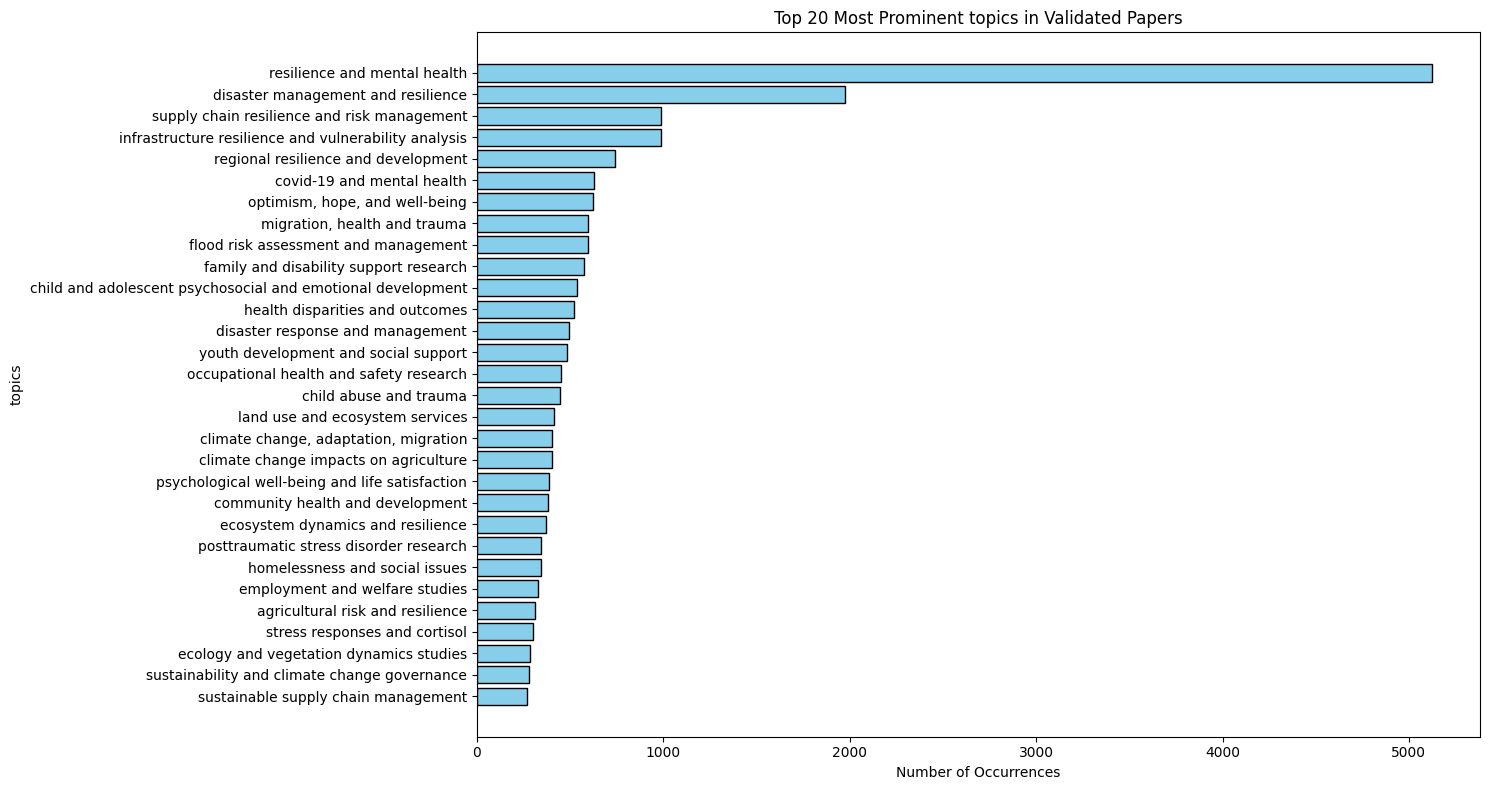

Top topics saved to 'top_topics.csv'.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

# ------------------------------------------------------------
# 1. Load Validated Data
# ------------------------------------------------------------
validated_df = pd.read_csv('validated_social_resilience_papers.csv')
# validated_df = validated_df[validated_df['source'] == 'seed'] ###########################################################################################

# Display dataset structure
print("Columns in dataset:", validated_df.columns)

# ------------------------------------------------------------
# 2. Extract and Clean topics
# ------------------------------------------------------------
# Ensure 'topics' column contains lists
validated_df['topics'] = validated_df['topics'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Flatten all topics into a single list
all_topics = [topics.strip().lower() for sublist in validated_df['topics'].dropna() for topics in sublist]

# Count topics occurrences
topics_counts = Counter(all_topics)
most_common_topics = topics_counts.most_common(30)  # Top 20 topics

# Display the most common topics
print("\nTop 30 Most Prominent topics:")
for topics, count in most_common_topics:
    print(f"{topics}: {count}")

# ------------------------------------------------------------
# 3. Visualize Top topics
# ------------------------------------------------------------
# Separate topics names and their counts
topics_names, topics_frequencies = zip(*most_common_topics)

# Bar Plot for Top topics
plt.figure(figsize=(15, 8))
plt.barh(topics_names[::-1], topics_frequencies[::-1], color='skyblue', edgecolor='black')
plt.title('Top 20 Most Prominent topics in Validated Papers')
plt.xlabel('Number of Occurrences')
plt.ylabel('topics')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4. Save topics Analysis Results
# ------------------------------------------------------------
topics_df = pd.DataFrame(most_common_topics, columns=['topics', 'Frequency'])
topics_df.to_csv('top_topics.csv', index=False)

print("Top topics saved to 'top_topics.csv'.")


Total papers before filtering: 16742
Total papers after filtering: 16742
Filtered dataset saved to 'filtered_social_resilience_papers.csv'.

Top 100 Most Prominent topics After Filtering:
resilience and mental health: 5125
disaster management and resilience: 1975
supply chain resilience and risk management: 990
infrastructure resilience and vulnerability analysis: 985
regional resilience and development: 740
covid-19 and mental health: 627
optimism, hope, and well-being: 622
migration, health and trauma: 598
flood risk assessment and management: 596
family and disability support research: 576


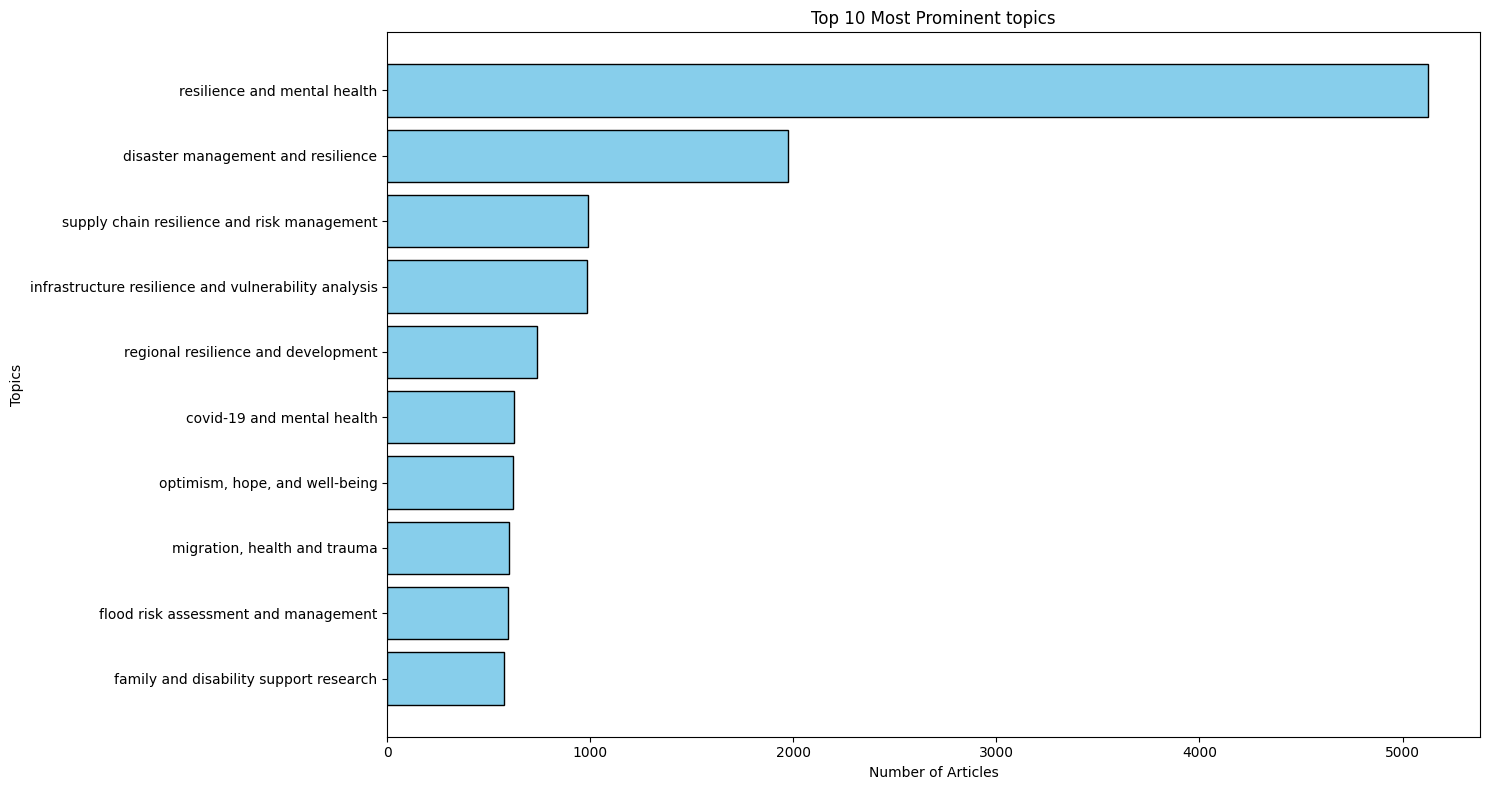

In [9]:
import pandas as pd
import ast

# ------------------------------------------------------------
# 1. Load Validated Data
# ------------------------------------------------------------
validated_df = pd.read_csv('validated_social_resilience_papers.csv')
# validated_df = validated_df[validated_df['source'] == 'seed'] ###########################################################################################

# Ensure 'topics' column contains lists
validated_df['topics'] = validated_df['topics'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# ------------------------------------------------------------
# 2. Define Relevant Social Resilience topics
# ------------------------------------------------------------
RELEVANT_topics = [
    "psychology",
    "psychological resilience",
    "social psychology",
    "political science",
    "sociology",
    "psychotherapist",
    "clinical psychology",
    "psychiatry",
    "developmental psychology",
    "social science",
    "social support"
]

# ------------------------------------------------------------
# 3. Filter Papers Based on Relevant topics
# ------------------------------------------------------------
def is_paper_relevant_by_topics(topics):
    """
    Check if any topics matches the relevant social resilience topics.
    """
    if not isinstance(topics, list):
        return False
    
    topics = [topics.strip().lower() for topics in topics]
    return any(topics in topics for topics in RELEVANT_topics)

# Apply filtering
filtered_df = validated_df  # [validated_df['topics'].apply(is_paper_relevant_by_topics)]

# Log the results
print(f"Total papers before filtering: {len(validated_df)}")
print(f"Total papers after filtering: {len(filtered_df)}")

# ------------------------------------------------------------
# 4. Save the Filtered Dataset
# ------------------------------------------------------------
filtered_df.to_csv('filtered_social_resilience_papers.csv', index=False)
print("Filtered dataset saved to 'filtered_social_resilience_papers.csv'.")

# ------------------------------------------------------------
# 5. Analyze Top topics Again
# ------------------------------------------------------------
from collections import Counter

# Flatten all topics in the filtered dataset
all_topics = [topics.strip().lower() for sublist in filtered_df['topics'].dropna() for topics in sublist]

# Count topics occurrences
topics_counts = Counter(all_topics)
most_common_topics = topics_counts.most_common(10)

batch_size = 100
total_topics = len(most_common_topics)

for i in range(0, total_topics, batch_size):
    # Print different header for the first batch vs. subsequent batches if needed
    if i == 0:
        print("\nTop 100 Most Prominent topics After Filtering:")
    else:
        print("\nNext 100 Most Prominent topics After Filtering:")
    
    # Print the current batch of topics
    for topic, count in most_common_topics[i:i + batch_size]:
        print(f"{topic}: {count}")


# ------------------------------------------------------------
# 6. Visualize Filtered topics
# ------------------------------------------------------------
import matplotlib.pyplot as plt

# Separate topics names and their counts
topics_names, topics_frequencies = zip(*most_common_topics)

# Bar Plot for Top topics
plt.figure(figsize=(15, 8))
plt.barh(topics_names[::-1], topics_frequencies[::-1], color='skyblue', edgecolor='black')
plt.title('Top 10 Most Prominent topics')
plt.xlabel('Number of Articles')
plt.ylabel('Topics')
plt.tight_layout()
plt.show()

Social Topics as extracted by ChatGPT o3-mini-high from a list of the 500 most prominent topics.
ChatGPT's definition of 'social resilience' was very broad first.

In [10]:
unfiltered_social_topics = [
    "resilience and mental health",
    "disaster management and resilience",
    "covid-19 and mental health",
    "optimism, hope, and well-being",
    "migration, health and trauma",
    "family and disability support research",
    "child and adolescent psychosocial and emotional development",
    "health disparities and outcomes",
    "disaster response and management",
    "youth development and social support",
    "child abuse and trauma",
    "psychological well-being and life satisfaction",
    "community health and development",
    "homelessness and social issues",
    "posttraumatic stress disorder research",
    "employment and welfare studies",
    "education and learning interventions",
    "psychosocial factors impacting youth",
    "grit, self-efficacy, and motivation",
    "early childhood education and development",
    "health and well-being studies",
    "health, psychology, and well-being",
    "childhood cancer survivors' quality of life",
    "family support in illness",
    "community development and social impact",
    "health and wellbeing research",
    "social work education and practice",
    "innovation and socioeconomic development",
    "covid-19 pandemic impacts",
    "poverty, education, and child welfare",
    "food security and health in diverse populations",
    "urban and rural development challenges",
    "lgbtq health, identity, and policy",
    "grief, bereavement, and mental health",
    "child welfare and adoption",
    "peacebuilding and international security",
    "suicide and self-harm studies",
    "mindfulness and compassion interventions",
    "mental health treatment and access",
    "intergenerational family dynamics and caregiving",
    "urban green space and health",
    "religion, spirituality, and psychology",
    "urban transport and accessibility",
    "indigenous studies and ecology",
    "child nutrition and water access",
    "cancer survivorship and care",
    "workplace health and well-being",
    "public relations and crisis communication",
    "environmental and social impact assessments",
    "social capital and networks",
    "youth education and societal dynamics",
    "family caregiving in mental illness",
    "racial and ethnic identity research",
    "mental health research topics",
    "social policy and reform studies",
    "evacuation and crowd dynamics",
    "facility location and emergency management",
    "global security and public health",
    "maternal mental health during pregnancy and postpartum",
    "indigenous health, education, and rights",
    "bullying, victimization, and aggression",
    "housing, finance, and neoliberalism",
    "innovative approaches in technology and social development",
    "education and experiences of immigrants and refugees",
    "international development and aid",
    "rural development and sustainability",
    "aging and gerontology research",
    "health and conflict studies",
    "long-term effects of covid-19",
    "urban, neighborhood, and segregation studies",
    "child nutrition and feeding issues",
    "corporate social responsibility reporting",
    "cultural heritage management and preservation",
    "korean urban and social studies",
    "student stress and coping",
    "french urban and social studies",
    "religion, society, and development",
    "emotional intelligence and performance",
    "social sciences and governance",
    "opinion dynamics and social influence",
    "regional development and policy",
    "intimate partner and family violence",
    "tourism, volunteerism, and development",
    "income, poverty, and inequality",
    "microfinance and financial inclusion",
    "mental health and patient involvement",
    "education discipline and inequality",
    "attachment and relationship dynamics",
    "educational systems and policies",
    "family dynamics and relationships",
    "urban planning and governance",
    "social media and politics",
    "art therapy and mental health",
    "public health and nutrition",
    "crime, illicit activities, and governance",
    "hiv, drug use, sexual risk",
    "misinformation and its impacts",
    "anxiety, depression, psychometrics, treatment, cognitive processes",
    "cambodian history and society",
    "child development and education",
    "educational methods and impacts",
    "digital mental health interventions",
    "criminal justice and corrections analysis",
    "migration, refugees, and integration",
    "banking, crisis management, covid-19 impact",
    "urban design and spatial analysis",
    "occupational therapy practice and research",
    "education practices and challenges",
    "youth substance use and school attendance",
    "environmental and cultural studies in latin america and beyond",
    "global socioeconomic and political dynamics",
    "identity, memory, and therapy",
    "health policy implementation science",
    "death anxiety and social exclusion",
    "aging, elder care, and social issues",
    "quality and safety in healthcare",
    "vietnamese history and culture studies",
    "china's socioeconomic reforms and governance",
    "nutrition and health in aging",
    "disability education and employment",
    "mental health via writing",
    "environmental justice and health disparities",
    "crime patterns and interventions",
    "teacher education and leadership studies",
    "labor market and education",
    "interprofessional education and collaboration",
    "regional development and environment",
    "service-learning and community engagement",
    "global maternal and child health",
    "cooperative studies and economics",
    "global health care issues",
    "cultural industries and urban development",
    "environmental education and sustainability",
    "adolescent sexual and reproductive health",
    "food security and socioeconomic dynamics",
    "psychology of development and education",
    "natural resources and economic development",
    "place attachment and urban studies",
    "social and intergroup psychology",
    "substance abuse treatment and outcomes",
    "children's rights and participation",
    "european union policy and governance",
    "financial literacy, pension, retirement analysis",
    "occupational health and performance",
    "middle east and rwanda conflicts",
    "land rights and reforms",
    "higher education research studies",
    "labor movements and unions",
    "stress and burnout research",
    "parental involvement in education",
    "leadership, courage, and heroism studies",
    "career development and diversity",
    "african studies and sociopolitical issues",
    "viral infections and outbreaks research",
    "climate change policy and economics",
    "global trade, sustainability, and social impact",
    "workplace violence and bullying",
    "child therapy and development",
    "climate change communication and perception",
    "digital marketing and social media",
    "workplace spirituality and leadership",
    "outdoor and experiential education",
    "global financial crisis and policies",
    "nursing education and management",
    "migration, ethnicity, and economy",
    "hiv/aids impact and responses",
    "political economy and marxism",
    "behavioral health and interventions",
    "education and character development",
    "education and islamic studies",
    "sex work and related issues",
    "eating disorders and behaviors",
    "education and critical thinking development",
    "southeast asian sociopolitical studies",
    "politics and conflicts in afghanistan, pakistan, and middle east",
    "school health and nursing education",
    "healthcare cost, quality, practices",
    "counseling, therapy, and family dynamics",
    "education systems and policy",
    "local governance and development",
    "education, achievement, and giftedness",
    "nonprofit sector and volunteering",
    "sociopolitical dynamics in russia",
    "global health workforce issues",
    "music therapy and health",
    "prenatal substance exposure effects",
    "hate speech and cyberbullying detection",
    "urbanization and city planning",
    "cultural differences and values",
    "child and adolescent health",
    "gender, security, and conflict",
    "regional socio-economic development trends",
    "mental health and well-being",
    "anthropological studies and insights",
    "elder abuse and neglect",
    "mental health and psychiatry",
    "public health policies and education",
    "gender, feminism, and media",
    "health, environment, cognitive aging",
    "retirement, disability, and employment"
]

# Refined social resilience related topics

The refinement was based on the following social resilience explanation:
"Social resilience is defined as the capacity of groups or communities to cope with external stresses and disturbances resulting from social, political, and environmental changes. It is closely linked to ecological resilience, which refers to ecosystems' ability to maintain themselves despite disturbances. However, the relationship between social and ecological resilience is complex, particularly for communities dependent on ecological resources for their livelihoods. Social resilience is characterized as a dynamic, multi-level, and evolutionary process that enables societies to not only cope with adversity but also adapt and transform themselves."


In [11]:
social_topics = [
    "resilience and mental health",
    "disaster management and resilience",
    "covid-19 and mental health",
    "optimism, hope, and well-being",
    "migration, health and trauma",
    "family and disability support research",
    "child and adolescent psychosocial and emotional development",
    "health disparities and outcomes",
    "disaster response and management",
    "youth development and social support",
    "psychological well-being and life satisfaction",
    "community health and development",
    "homelessness and social issues",
    "posttraumatic stress disorder research",
    "employment and welfare studies",
    "education and learning interventions",
    "psychosocial factors impacting youth",
    "grit, self-efficacy, and motivation",
    "early childhood education and development",
    "health and well-being studies",
    "health, psychology, and well-being",
    "family support in illness",
    "community development and social impact",
    "health and wellbeing research",
    "social work education and practice",
    "innovation and socioeconomic development",
    "covid-19 pandemic impacts",
    "poverty, education, and child welfare",
    "food security and health in diverse populations",
    "urban and rural development challenges",
    "lgbtq health, identity, and policy",
    "grief, bereavement, and mental health",
    "child welfare and adoption",
    "peacebuilding and international security",
    "mindfulness and compassion interventions",
    "mental health treatment and access",
    "intergenerational family dynamics and caregiving",
    "urban green space and health",
    "religion, spirituality, and psychology",
    "child nutrition and water access",
    "workplace health and well-being",
    "public relations and crisis communication",
    "environmental and social impact assessments",
    "social capital and networks",
    "youth education and societal dynamics",
    "family caregiving in mental illness",
    "racial and ethnic identity research",
    "mental health research topics",
    "social policy and reform studies",
    "evacuation and crowd dynamics",
    "facility location and emergency management",
    "global security and public health",
    "maternal mental health during pregnancy and postpartum",
    "indigenous health, education, and rights",
    "bullying, victimization, and aggression",
    "housing, finance, and neoliberalism",
    "innovative approaches in technology and social development",
    "education and experiences of immigrants and refugees",
    "international development and aid",
    "rural development and sustainability",
    "aging and gerontology research",
    "health and conflict studies",
    "long-term effects of covid-19",
    "urban, neighborhood, and segregation studies",
    "child nutrition and feeding issues",
    "corporate social responsibility reporting",
    "cultural heritage management and preservation",
    "korean urban and social studies",
    "student stress and coping",
    "french urban and social studies",
    "religion, society, and development",
    "social sciences and governance",
    "opinion dynamics and social influence",
    "regional development and policy",
    "intimate partner and family violence",
    "tourism, volunteerism, and development",
    "income, poverty, and inequality",
    "microfinance and financial inclusion",
    "mental health and patient involvement",
    "education discipline and inequality",
    "attachment and relationship dynamics",
    "educational systems and policies",
    "family dynamics and relationships",
    "urban planning and governance",
    "social media and politics",
    "art therapy and mental health",
    "public health and nutrition",
    "crime, illicit activities, and governance",
    "hiv, drug use, sexual risk",
    "misinformation and its impacts",
    "anxiety, depression, psychometrics, treatment, cognitive processes",
    "child development and education",
    "educational methods and impacts",
    "digital mental health interventions",
    "criminal justice and corrections analysis",
    "migration, refugees, and integration",
    "banking, crisis management, covid-19 impact",
    "urban design and spatial analysis",
    "education practices and challenges",
    "environmental and cultural studies in latin america and beyond",
    "global socioeconomic and political dynamics",
    "identity, memory, and therapy",
    "health policy implementation science",
    "death anxiety and social exclusion",
    "aging, elder care, and social issues",
    "quality and safety in healthcare",
    "china's socioeconomic reforms and governance",
    "nutrition and health in aging",
    "disability education and employment",
    "mental health via writing",
    "environmental justice and health disparities",
    "crime patterns and interventions",
    "teacher education and leadership studies",
    "labor market and education",
    "interprofessional education and collaboration",
    "regional development and environment",
    "service-learning and community engagement",
    "global maternal and child health",
    "cooperative studies and economics",
    "global health care issues",
    "cultural industries and urban development",
    "environmental education and sustainability",
    "adolescent sexual and reproductive health",
    "food security and socioeconomic dynamics",
    "psychology of development and education",
    "natural resources and economic development",
    "place attachment and urban studies",
    "social and intergroup psychology",
    "substance abuse treatment and outcomes",
    "children's rights and participation",
    "european union policy and governance",
    "financial literacy, pension, retirement analysis",
    "occupational health and performance",
    "middle east and rwanda conflicts",
    "land rights and reforms",
    "higher education research studies",
    "labor movements and unions",
    "stress and burnout research",
    "parental involvement in education",
    "leadership, courage, and heroism studies",
    "career development and diversity",
    "african studies and sociopolitical issues",
    "viral infections and outbreaks research",
    "climate change policy and economics",
    "global trade, sustainability, and social impact",
    "workplace violence and bullying",
    "child therapy and development",
    "climate change communication and perception",
    "digital marketing and social media",
    "workplace spirituality and leadership",
    "outdoor and experiential education",
    "global financial crisis and policies",
    "nursing education and management"
]


<ipython-input-12-81442fcf393e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['topics'] = filtered_df['topics'].apply(


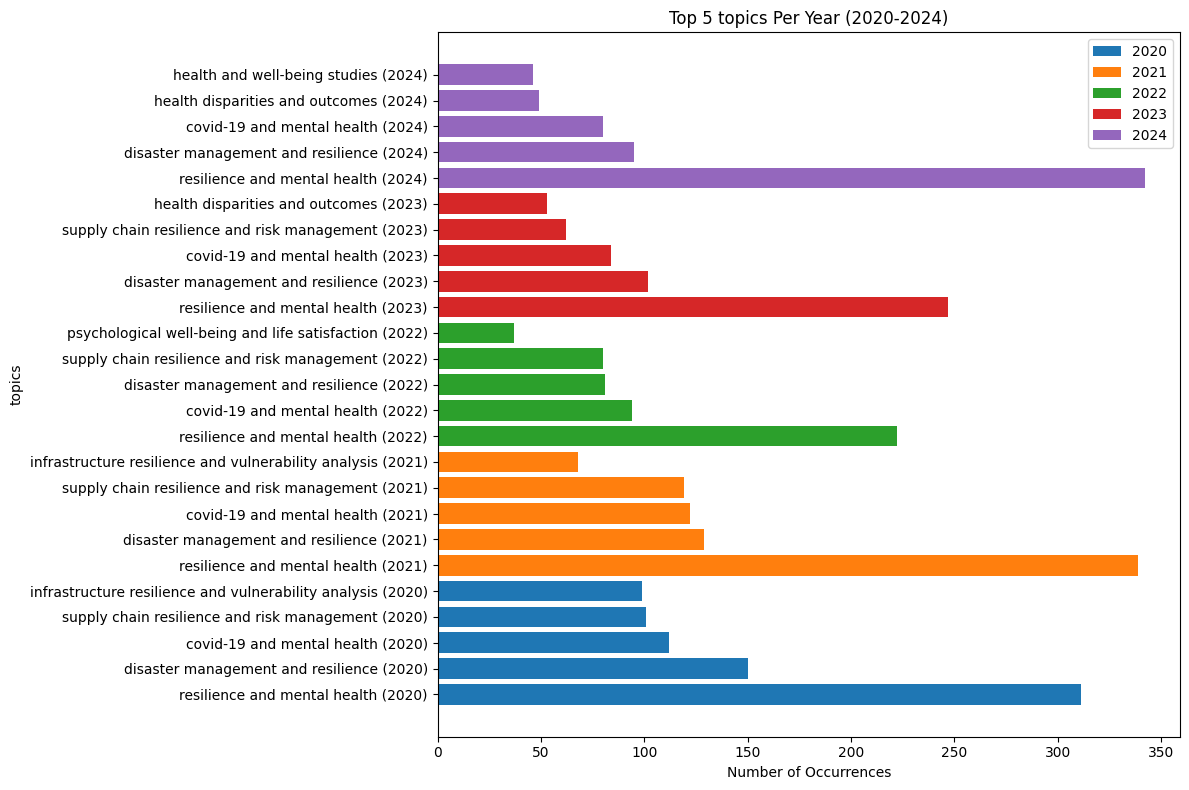

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

# Load Validated Data
validated_df = pd.read_csv('validated_social_resilience_papers.csv')
validated_df = validated_df[validated_df['source'] == 'seed'] ###########################################################################################


# Extract and Clean Publication Years
validated_df['publication_year'] = pd.to_numeric(validated_df['publication_year'], errors='coerce')
validated_df = validated_df.dropna(subset=['publication_year'])
validated_df['publication_year'] = validated_df['publication_year'].astype(int)

# Filter for Years 2020-2024
filtered_df = validated_df[(validated_df['publication_year'] >= 2020) & (validated_df['publication_year'] <= 2024)]

# Extract and Clean topics
filtered_df['topics'] = filtered_df['topics'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Find Top 5 topics Per Year
years = filtered_df['publication_year'].unique()
top_topics_per_year = {}

for year in years:
    yearly_df = filtered_df[filtered_df['publication_year'] == year]
    all_topics = [topics.strip().lower() for sublist in yearly_df['topics'].dropna() for topics in sublist]
    topics_counts = Counter(all_topics)
    top_topics_per_year[year] = topics_counts.most_common(5)

# Visualization
plt.figure(figsize=(12, 8))
for year, topics in top_topics_per_year.items():
    topics_names, topics_frequencies = zip(*topics)
    plt.barh([f"{topics} ({year})" for topics in topics_names], topics_frequencies, label=f"{year}")

plt.title('Top 5 topics Per Year (2020-2024)')
plt.xlabel('Number of Occurrences')
plt.ylabel('topics')
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-13-5246b4d5d269>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['topics'] = filtered_df['topics'].apply(


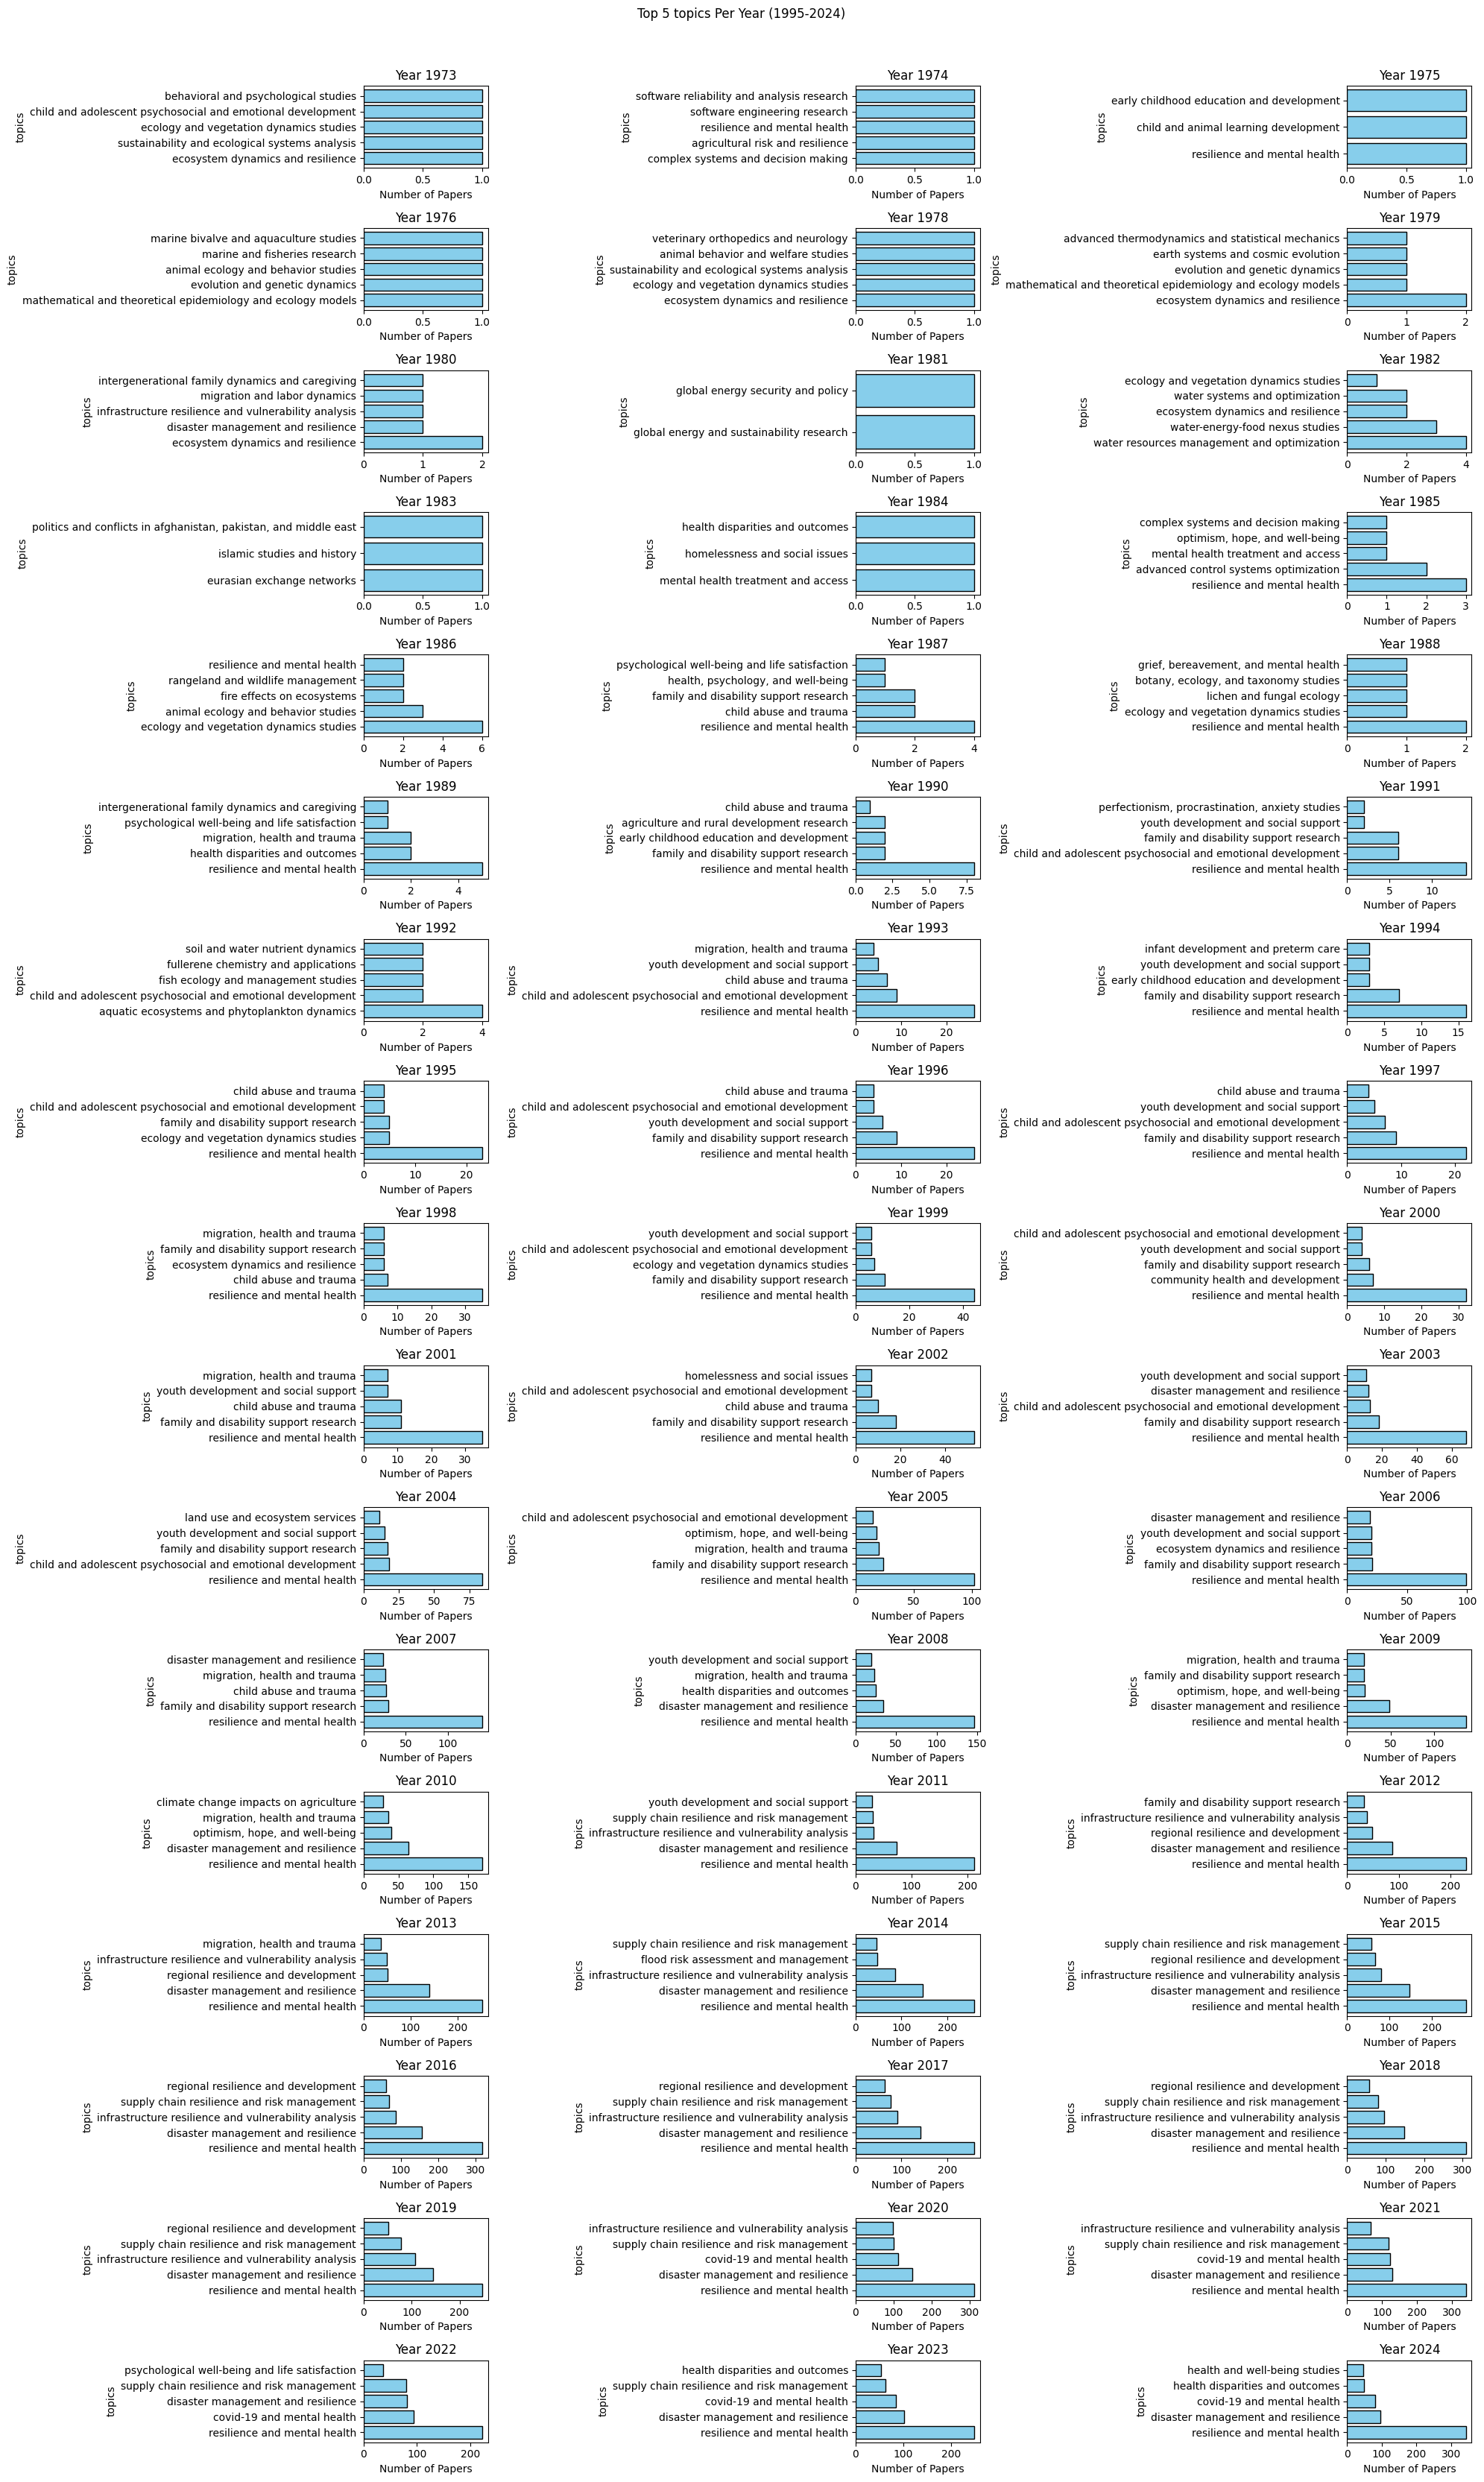

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

# Extract and Clean Publication Years
validated_df['publication_year'] = pd.to_numeric(validated_df['publication_year'], errors='coerce')
validated_df = validated_df.dropna(subset=['publication_year'])
validated_df['publication_year'] = validated_df['publication_year'].astype(int)

# Filter for Years 1995-2024
filtered_df = validated_df[(validated_df['publication_year'] >= 1973) & (validated_df['publication_year'] <= 2024)]

# Extract and Clean topics
filtered_df['topics'] = filtered_df['topics'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Find Top 5 topics Per Year
years = sorted(filtered_df['publication_year'].unique())
top_topics_per_year = {}

for year in years:
    yearly_df = filtered_df[filtered_df['publication_year'] == year]
    all_topics = [topics.strip().lower() for sublist in yearly_df['topics'].dropna() for topics in sublist]
    topics_counts = Counter(all_topics)
    top_topics_per_year[year] = topics_counts.most_common(5)

# Visualization
fig, axes = plt.subplots(17, 3, figsize=(20, 35))
fig.suptitle('Top 5 topics Per Year (1995-2024)')

for idx, year in enumerate(years):
    row, col = divmod(idx, 3)
    ax = axes[row, col]
    if year in top_topics_per_year:
        topics_names, topics_frequencies = zip(*top_topics_per_year[year])
        ax.barh(topics_names, topics_frequencies, color='skyblue', edgecolor='black')
        ax.set_title(f'Year {year}')
        ax.set_xlabel('Number of Papers')
        ax.set_ylabel('topics')
    else:
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


<ipython-input-14-b90c4cdec6ef>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['topics'] = filtered_df['topics'].apply(


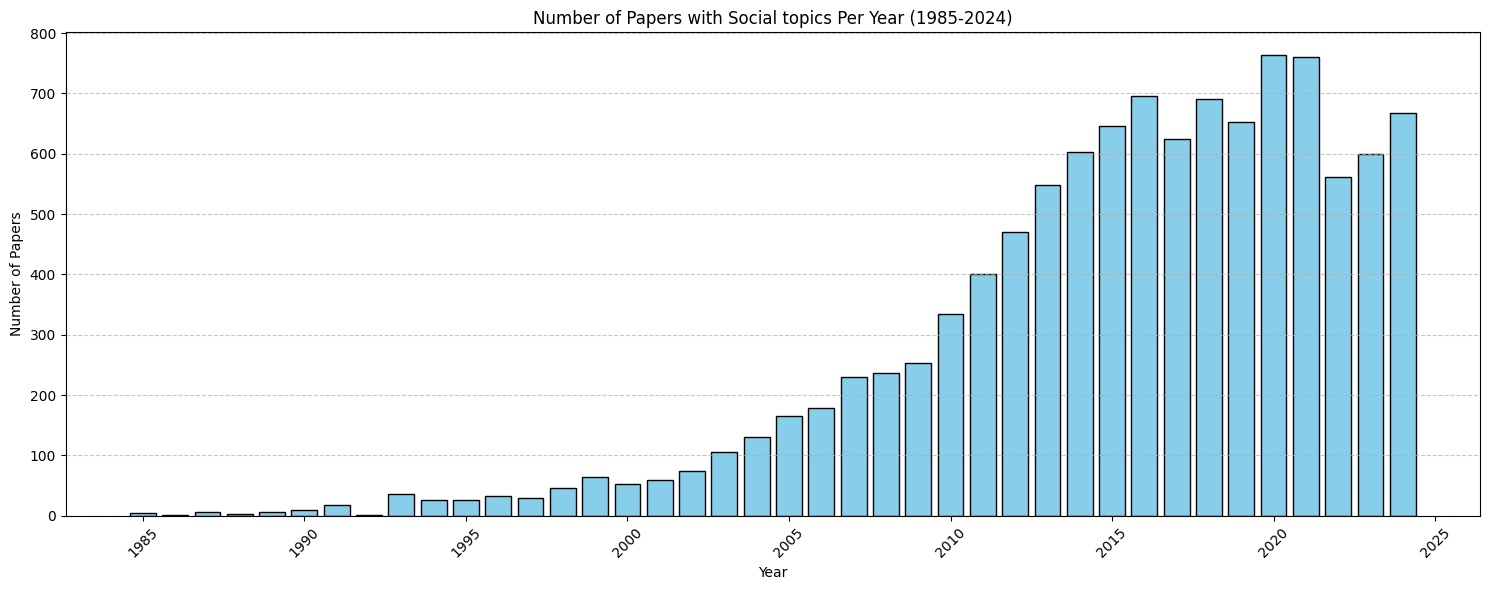

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

# Load Validated Data
validated_df = pd.read_csv('validated_social_resilience_papers.csv')
validated_df = validated_df[validated_df['source'] == 'seed'] ###########################################################################################


# Extract and Clean Publication Years
validated_df['publication_year'] = pd.to_numeric(validated_df['publication_year'], errors='coerce')
validated_df = validated_df.dropna(subset=['publication_year'])
validated_df['publication_year'] = validated_df['publication_year'].astype(int)

# Filter for Years 1985-2024
filtered_df = validated_df[(validated_df['publication_year'] >= 1985) & (validated_df['publication_year'] <= 2024)]

# Extract and Clean topics
filtered_df['topics'] = filtered_df['topics'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Count Papers Containing Social topics Per Year
years = sorted(filtered_df['publication_year'].unique())
social_topics_per_year = {year: 0 for year in years}
total_papers_per_year = filtered_df['publication_year'].value_counts().to_dict()

for year in years:
    yearly_df = filtered_df[filtered_df['publication_year'] == year]
    count = 0
    for topics in yearly_df['topics'].dropna():
        if any(topics.lower().strip() in social_topics for topics in topics):
            count += 1
    social_topics_per_year[year] = count

# Plot absolute number of papers with social topics
plt.figure(figsize=(15, 6))
plt.bar(social_topics_per_year.keys(), social_topics_per_year.values(), color='skyblue', edgecolor='black')
plt.title('Number of Papers with Social topics Per Year (1985-2024)')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


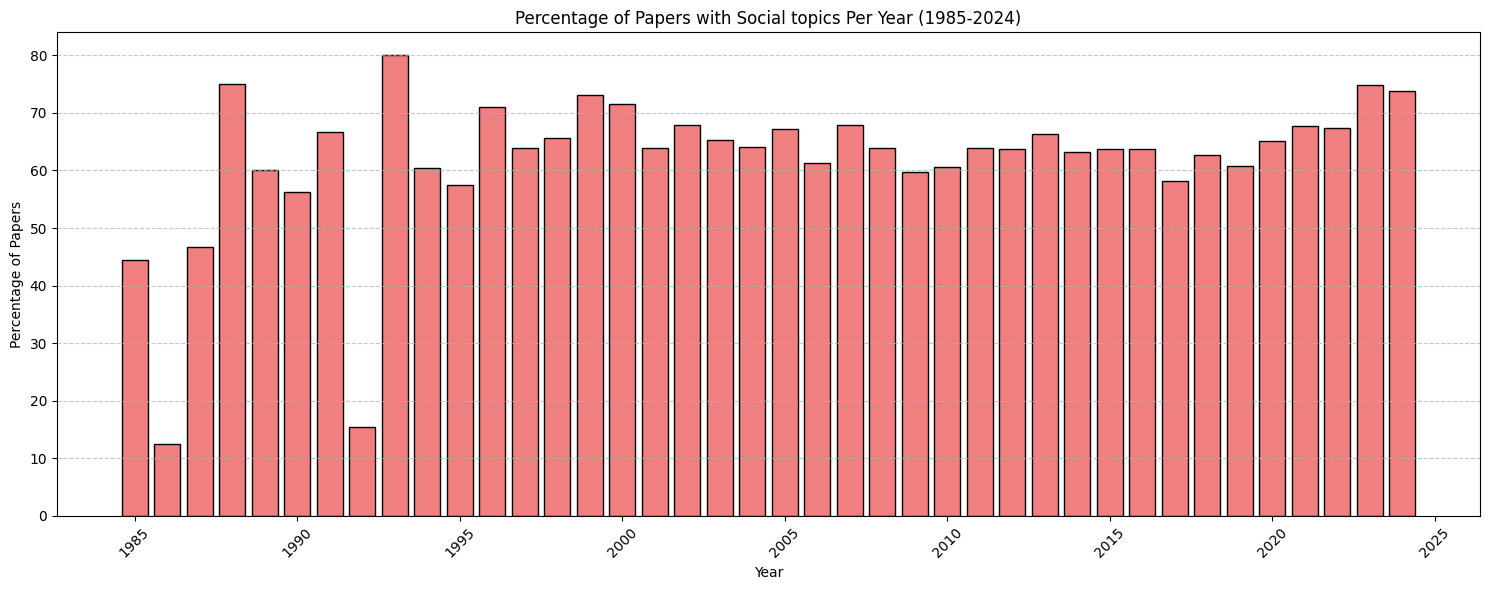

In [15]:
# Calculate and plot percentage of papers with social topics per year
percent_social_topics_per_year = {
    year: (social_topics_per_year[year] / total_papers_per_year.get(year, 1)) * 100
    for year in years
}
 
plt.figure(figsize=(15, 6))
plt.bar(percent_social_topics_per_year.keys(), percent_social_topics_per_year.values(), color='lightcoral', edgecolor='black')
plt.title('Percentage of Papers with Social topics Per Year (1985-2024)')
plt.xlabel('Year')
plt.ylabel('Percentage of Papers')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [16]:
import networkx as nx

# Create co-authorship network
G = nx.Graph()

# Add edges between co-authors
for _, row in authors_df.iterrows():
    authors = [a.get('author_name') for a in row.get('authors', [])]
    for i in range(len(authors)):
        for j in range(i+1, len(authors)):
            if authors[i] and authors[j]:  # Ensure names aren't None
                if G.has_edge(authors[i], authors[j]):
                    G[authors[i]][authors[j]]['weight'] += 1
                else:
                    G.add_edge(authors[i], authors[j], weight=1)

# Find key collaborators
centrality = nx.degree_centrality(G)
top_collaborators = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:20]
top_collaborators

[('David A. Bennett', 0.005797619655718445),
 ('Carl Folke', 0.005644378607549676),
 ('Klaus Lieb', 0.0038821065536088265),
 ('Eric J. Nestler', 0.0038054860295244418),
 ('Margaret A. Pericak‐Vance', 0.003728865505440057),
 ('David W. Fardo', 0.0037033253307452623),
 ('Raffaël Kalisch', 0.003550084282576493),
 ('Nick C. Fox', 0.003499003933186903),
 ('Oliver Tüscher', 0.003473463758492108),
 ('John Kauwe', 0.0032946825356285434),
 ('Rita Guerreiro', 0.0032691423609337487),
 ('José Brás', 0.0032691423609337487),
 ('Igor Linkov', 0.0032180620115441587),
 ('Lyonna F. Parise', 0.0032180620115441587),
 ('Flurin Cathomas', 0.003192521836849364),
 ('Philip L. De Jager', 0.003141441487459774),
 ('Craig R. Allen', 0.003115901312764979),
 ('Ilya M. Veer', 0.003115901312764979),
 ('Birgit Kleim', 0.0030137406139857997),
 ('Talma Hendler', 0.0030137406139857997)]

In [17]:
import ast
import pandas as pd

# Convert string representation to actual Python objects
authors_df['authors'] = authors_df['authors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Expand authors
authors_expanded = authors_df.explode('authors')
authors_expanded['author_name'] = authors_expanded['authors'].apply(lambda x: x.get('author_name') if isinstance(x, dict) else None)
authors_expanded['author_id'] = authors_expanded['authors'].apply(lambda x: x.get('author_id') if isinstance(x, dict) else None)
authors_expanded['author_orcid'] = authors_expanded['authors'].apply(lambda x: x.get('author_orcid') if isinstance(x, dict) else None)

# Find the most cited paper for each author
if 'citation_count' in authors_df.columns:
    author_papers = authors_expanded[['author_name', 'id', 'title', 'citation_count']].copy()
    
    # Get the most cited paper for each author
    most_cited_paper = author_papers.sort_values('citation_count', ascending=False).drop_duplicates('author_name')
    most_cited_paper = most_cited_paper[['author_name', 'title', 'citation_count']]
    most_cited_paper.columns = ['author_name', 'most_cited_paper_title', 'most_cited_paper_citations']
else:
    most_cited_paper = pd.DataFrame(columns=['author_name', 'most_cited_paper_title', 'most_cited_paper_citations'])

# Count papers by author
author_counts = authors_expanded.groupby('author_name').size().reset_index(name='paper_count')

# Track citation counts
if 'citation_count' in authors_df.columns:
    author_impact = authors_expanded.groupby('author_name')['citation_count'].sum().reset_index()
else:
    author_impact = pd.DataFrame(columns=['author_name', 'citation_count'])
    author_impact['citation_count'] = 0

# Calculate years active for each author
author_years_active = authors_expanded.groupby('author_name')['publication_year'].nunique().reset_index(name='years_active')

# Calculate first publication year for each author
author_first_pub = authors_expanded.groupby('author_name')['publication_year'].min().reset_index(name='first_publication_year')

# Calculate most recent publication year
author_last_pub = authors_expanded.groupby('author_name')['publication_year'].max().reset_index(name='last_publication_year')

# Get author primary institutions
def get_institutions(author_data):
    if isinstance(author_data, dict) and 'institutions' in author_data:
        institutions = author_data['institutions']
        if institutions and len(institutions) > 0:
            if isinstance(institutions[0], dict):
                return institutions[0].get('institution_name', '')
    return None

authors_expanded['primary_institution'] = authors_expanded['authors'].apply(get_institutions)
author_institutions = authors_expanded.groupby('author_name')['primary_institution'].apply(
    lambda x: x.value_counts().index[0] if not x.isna().all() and len(x.value_counts()) > 0 else None
).reset_index()

# Get author countries
def get_country(author_data):
    if isinstance(author_data, dict) and 'institutions' in author_data:
        institutions = author_data['institutions']
        if institutions and len(institutions) > 0:
            if isinstance(institutions[0], dict):
                return institutions[0].get('country_code', '')
    return None

authors_expanded['country'] = authors_expanded['authors'].apply(get_country)
author_countries = authors_expanded.groupby('author_name')['country'].apply(
    lambda x: x.value_counts().index[0] if not x.isna().all() and len(x.value_counts()) > 0 else None
).reset_index()

# Count co-authors
author_papers = authors_expanded.groupby(['author_name', 'id']).size().reset_index()[['author_name', 'id']]
coauthor_counts = author_papers.merge(
    authors_expanded.groupby('id').size().reset_index(name='authors_count'), 
    on='id'
)
avg_coauthors = coauthor_counts.groupby('author_name')['authors_count'].mean().reset_index(name='avg_coauthors')

# Merge all data into one comprehensive author DataFrame
comprehensive_author_df = author_counts.merge(
    author_impact, on='author_name', how='left'
).merge(
    author_years_active, on='author_name', how='left'
).merge(
    author_first_pub, on='author_name', how='left'
).merge(
    author_last_pub, on='author_name', how='left'
).merge(
    author_institutions, on='author_name', how='left'
).merge(
    author_countries, on='author_name', how='left'
).merge(
    avg_coauthors, on='author_name', how='left'
).merge(
    most_cited_paper, on='author_name', how='left'
)

# Calculate author career span
comprehensive_author_df['career_span'] = comprehensive_author_df['last_publication_year'] - comprehensive_author_df['first_publication_year']

# Fix the yearly authors count
yearly_authors = authors_expanded.groupby('publication_year')['author_name'].nunique().reset_index(name='unique_authors')

# Fix the new authors by year count
first_pubs = author_first_pub.copy()
new_authors_by_year = first_pubs['first_publication_year'].value_counts().sort_index().reset_index()
new_authors_by_year.columns = ['year', 'new_authors']

# Sort the comprehensive author data by paper count (most prolific first)
comprehensive_author_df = comprehensive_author_df.sort_values('paper_count', ascending=False)

# Fill missing values
comprehensive_author_df = comprehensive_author_df.fillna({
    'citation_count': 0,
    'avg_coauthors': 0,
    'career_span': 0,
    'most_cited_paper_citations': 0,
    'most_cited_paper_title': 'Unknown'
})

comprehensive_author_df.to_csv('authors_data.csv', index=False)
comprehensive_author_df

,author_name,paper_count,citation_count,years_active,first_publication_year,last_publication_year,primary_institution,country,avg_coauthors,most_cited_paper_title,most_cited_paper_citations,career_span
26202,Michael Ungar,83,14967,21,2001,2023,Dalhousie University,CA,2.843373,Resilience across Cultures,1645,22
2553,Ann S. Masten,78,37155,27,1986,2021,University of Minnesota,US,2.538462,Ordinary magic: Resilience processes in develo...,5342,35
5306,Carl Folke,71,49210,23,1994,2021,Stockholm University,SE,6.450704,Resilience: The emergence of a perspective for...,6549,27
4773,Brian Walker,48,36804,22,1980,2021,Commonwealth Scientific and Industrial Researc...,AU,5.125000,"Resilience, Adaptability and Transformability ...",6549,41
14873,Igor Linkov,46,6559,12,2012,2024,U.S. Army Engineer Research and Development Ce...,US,5.347826,Changing the resilience paradigm,605,12
...,...,...,...,...,...,...,...,...,...,...,...,...
15234,Isabelle Durance,1,0,1,2018,2018,None,None,2.000000,Resilience and Adaptation in Coupled Natural-S...,0,0
15235,Isabelle Lussier,1,64,1,2007,2007,McGill University,CA,5.000000,Youth gambling behaviors: An examination of th...,64,0
15237,Isabelle M. Mansuy,1,449,1,2012,2012,None,None,3.000000,Neural Mechanisms of Stress Resilience and Vul...,449,0
15238,Isabelle Maréchaux,1,68,1,2019,2019,Institut de Recherche pour le Développement,FR,7.000000,Functional diversity improves tropical forest ...,68,0


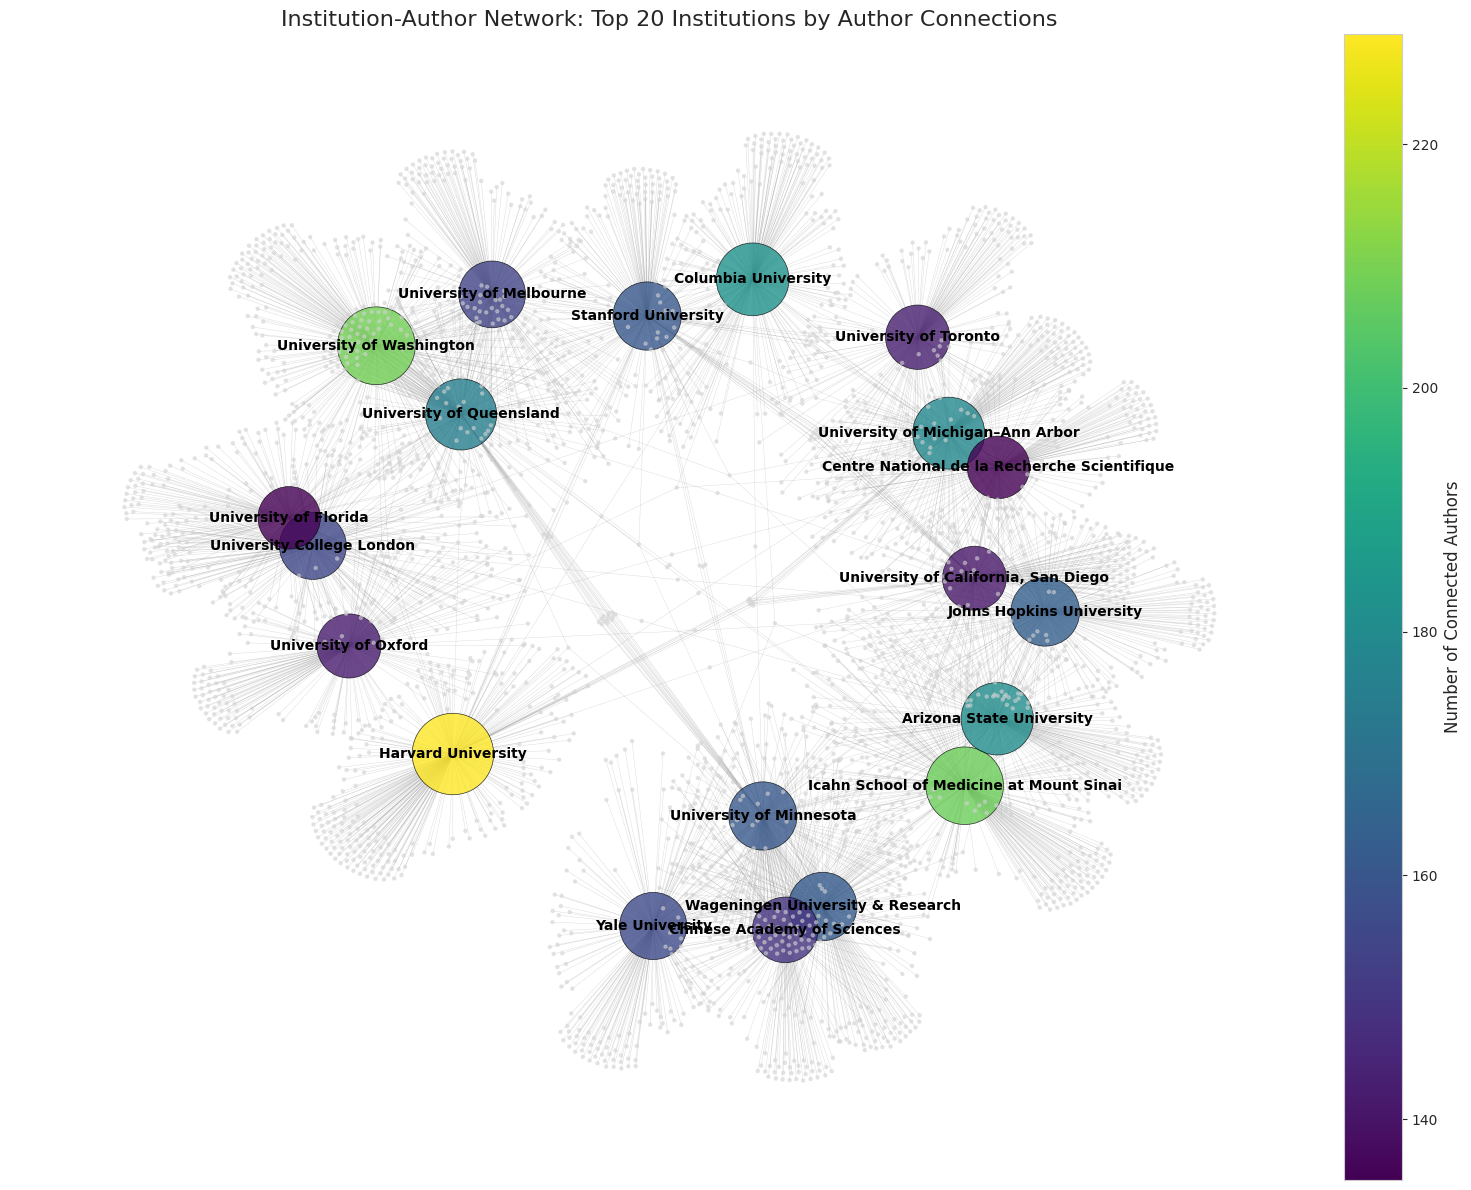

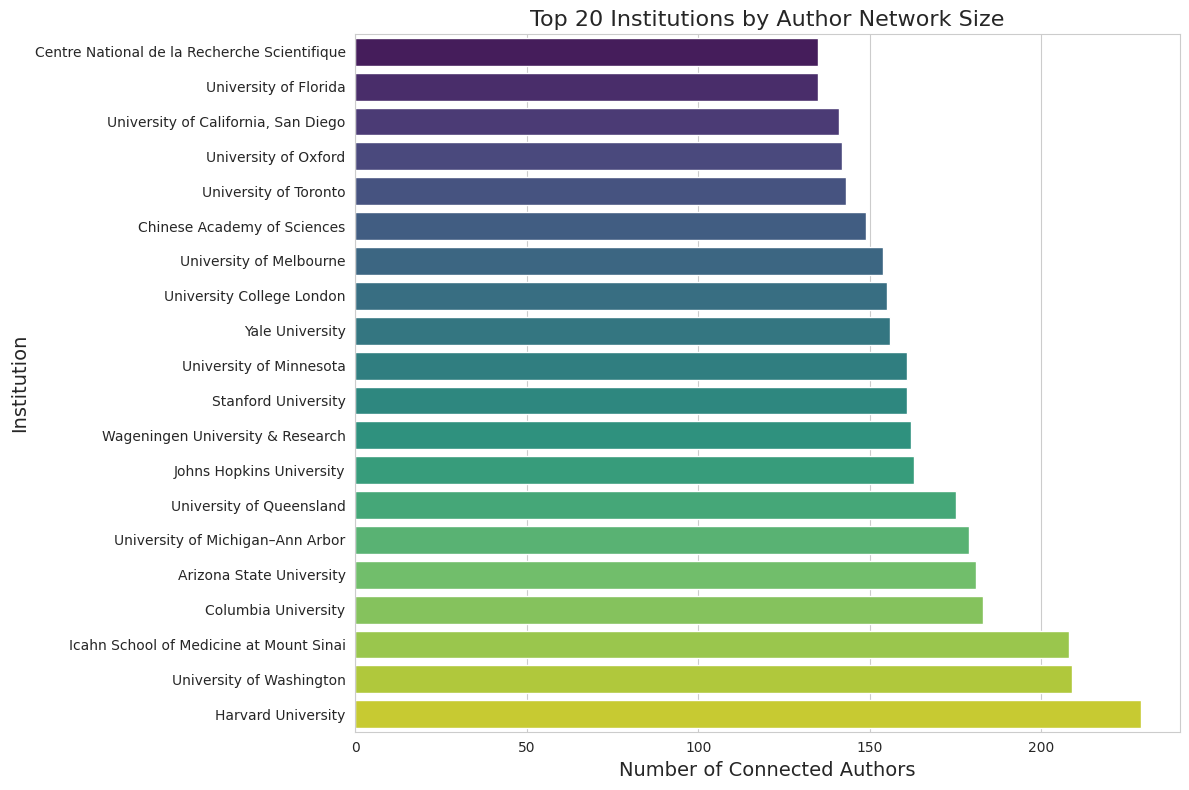

CPU times: user 12min 56s, sys: 2.02 s, total: 12min 58s
Wall time: 12min 57s


In [18]:
%%time
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Assuming authors_df has already been loaded and processed
# Using your code to process the data:

# Flatten the nested structure to get all institution entries
institutions_list = []
for _, row in authors_df.iterrows():
    for author in row.get('authors', []):
        for inst in author.get('institutions', []):
            inst_data = {
                'paper_id': row['id'],
                'publication_year': row['publication_year'],
                'institution_name': inst.get('institution_name'),
                'country_code': inst.get('country_code')
            }
            institutions_list.append(inst_data)
inst_df = pd.DataFrame(institutions_list)
top_institutions = inst_df['institution_name'].value_counts().reset_index()
top_institutions.columns = ['institution_name', 'paper_count']
top_institutions = top_institutions.head(20)

# Create bipartite graph of authors and institutions
B = nx.Graph()
for _, row in authors_df.iterrows():
    for author in row.get('authors', []):
        author_name = author.get('author_name')
        for inst in author.get('institutions', []):
            inst_name = inst.get('institution_name')
            if author_name and inst_name:
                B.add_edge(author_name, inst_name)

# Find institutions with most diverse author networks
institution_degrees = {node: val for node, val in B.degree() 
                      if node in set(inst_df['institution_name'])}
top_networked_institutions = sorted(institution_degrees.items(), 
                                    key=lambda x: x[1], reverse=True)[:20]

# Create a filtered graph with only the top institutions and their connected authors
top_inst_names = [inst for inst, _ in top_networked_institutions]
filtered_G = nx.Graph()

for inst_name in top_inst_names:
    # Get all neighbors (authors) of this institution
    if inst_name in B:
        neighbors = list(B.neighbors(inst_name))
        
        # Add edges between institution and its authors
        for author in neighbors:
            filtered_G.add_edge(inst_name, author)

# Create a visualization
plt.figure(figsize=(16, 12))
sns.set_style("whitegrid")

# Create node positions using spring layout
pos = nx.spring_layout(filtered_G, k=0.15, iterations=100, seed=42)

# Identify node types
institution_nodes = [node for node in filtered_G.nodes() if node in top_inst_names]
author_nodes = [node for node in filtered_G.nodes() if node not in top_inst_names]

# Calculate node sizes based on degree
inst_sizes = [filtered_G.degree(node) * 15 for node in institution_nodes]
author_sizes = [5 for _ in author_nodes]

# Create a custom colormap for institutions based on their network size
inst_degrees = [institution_degrees[inst] for inst in institution_nodes]
norm = plt.Normalize(min(inst_degrees), max(inst_degrees))
cmap = plt.cm.viridis

# Draw the network
# Draw institution nodes
nx.draw_networkx_nodes(filtered_G, pos, 
                       nodelist=institution_nodes,
                       node_size=inst_sizes,
                       node_color=inst_degrees,
                       cmap=cmap,
                       alpha=0.8,
                       edgecolors='black',
                       linewidths=0.5)

# Draw author nodes
nx.draw_networkx_nodes(filtered_G, pos, 
                       nodelist=author_nodes,
                       node_size=author_sizes,
                       node_color='lightgrey',
                       alpha=0.5)

# Draw edges
nx.draw_networkx_edges(filtered_G, pos, 
                       width=0.3, 
                       alpha=0.3, 
                       edge_color='grey')

# Label only institution nodes
nx.draw_networkx_labels(filtered_G, pos, 
                       labels={n: n for n in institution_nodes},
                       font_size=10,
                       font_weight='bold')

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.01)
cbar.set_label('Number of Connected Authors', fontsize=12)

# Add title and adjust layout
plt.title('Institution-Author Network: Top 20 Institutions by Author Connections', fontsize=16)
plt.tight_layout()
plt.axis('off')

# Show plot
plt.savefig('institution_author_network.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional visualization: Top institutions bar chart
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create dataframe of top networked institutions for the bar chart
top_networked_df = pd.DataFrame(top_networked_institutions, columns=['institution_name', 'author_connections'])
top_networked_df = top_networked_df.sort_values('author_connections', ascending=True)

# Create bar chart
bars = sns.barplot(x='author_connections', y='institution_name', data=top_networked_df, 
                  palette='viridis')

plt.title('Top 20 Institutions by Author Network Size', fontsize=16)
plt.xlabel('Number of Connected Authors', fontsize=14)
plt.ylabel('Institution', fontsize=14)
plt.tight_layout()

plt.savefig('top_networked_institutions.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
%%time
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re

# Download NLTK resources if needed
nltk.download('stopwords')
nltk.download('punkt')

# Preprocess abstracts
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 3]
    return tokens

# Apply preprocessing to all abstracts
authors_df['tokens'] = authors_df['abstract'].apply(preprocess_text)

# Get most common terms across all abstracts
all_tokens = [token for tokens_list in authors_df['tokens'].tolist() for token in tokens_list]
most_common_terms = Counter(all_tokens).most_common(30)

print("Most common terms in resilience research:")
for term, count in most_common_terms:
    print(f"{term}: {count}")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Most common terms in resilience research:
resilience: 36666
social: 17906
study: 8127
support: 7038
research: 5962
health: 4688
community: 4060
stress: 4021
results: 3911
factors: 3663
systems: 3486
data: 3426
also: 3324
risk: 3310
development: 3249
analysis: 3242
change: 3236
using: 3092
system: 2961
psychological: 2951
paper: 2898
used: 2880
among: 2870
resilient: 2769
model: 2730
students: 2695
management: 2672
positive: 2668
findings: 2616
life: 2594
CPU times: user 14.3 s, sys: 768 ms, total: 15 s
Wall time: 15.8 s


In [20]:
# %%time
# from gensim import corpora, models
# import pyLDAvis.gensim_models

# # Prepare corpus for LDA
# dictionary = corpora.Dictionary(authors_df['tokens'])
# corpus = [dictionary.doc2bow(text) for text in authors_df['tokens']]

# # Build LDA model
# num_topics = 20
# lda_model = models.LdaModel(corpus=corpus,
#                            id2word=dictionary,
#                            num_topics=num_topics,
#                            passes=30)

# # Print topics
# print("Top topics in resilience research:")
# for idx, topic in lda_model.print_topics(-1):
#     print(f"Topic {idx}: {topic}")

# # Visualize topics (save to HTML file)
# vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
# pyLDAvis.save_html(vis_data, 'lda_visualization.html')

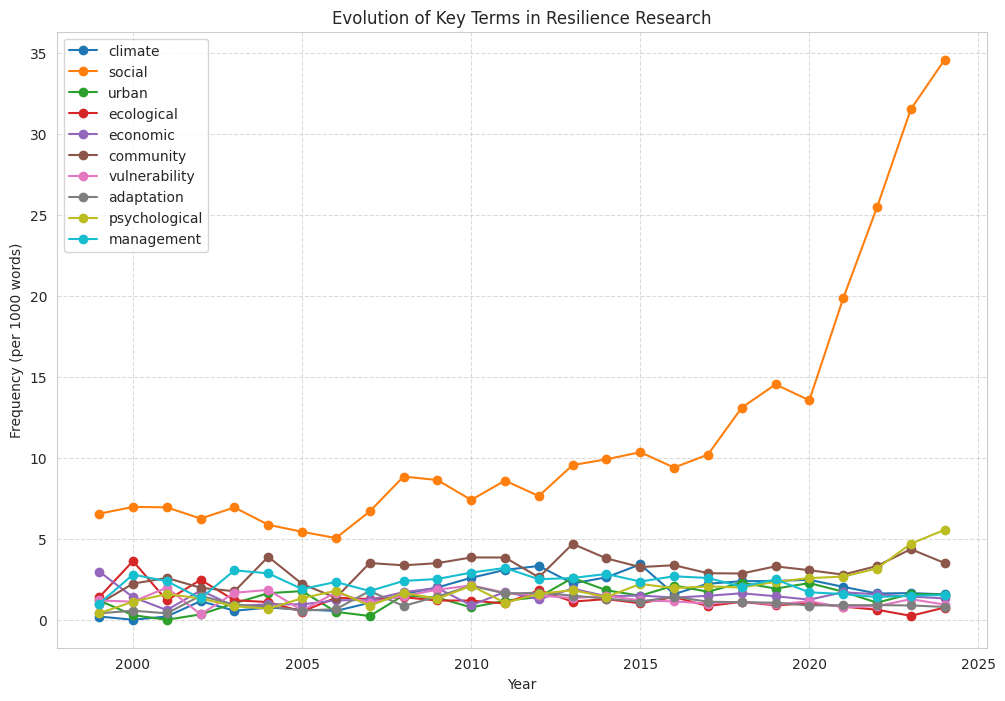

CPU times: user 1.26 s, sys: 161 ms, total: 1.42 s
Wall time: 1.18 s


In [21]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Group abstracts by year
year_tokens = {}
for year, group in authors_df.groupby('publication_year'):
    if isinstance(year, (int, float)) and not np.isnan(year):
        year = int(year)
        year_tokens[year] = [token for tokens_list in group['tokens'].tolist() for token in tokens_list]

# Select key terms to track
key_terms = ['climate', 'social', 'urban', 'ecological', 'economic',
             'community', 'vulnerability', 'adaptation','psychological',
            'management']
term_evolution = {term: {} for term in key_terms}

# Calculate term frequency by year
for year, tokens in year_tokens.items():
    total_tokens = len(tokens)
    if year < 1999:
        continue
    if total_tokens > 0:
        counter = Counter(tokens)
        for term in key_terms:
            term_evolution[term][year] = counter.get(term, 0) / total_tokens * 1000  # Occurrences per 1000 words

# Create dataframe for plotting
term_df = pd.DataFrame(term_evolution)
term_df = term_df.sort_index()

# Plot evolution of key terms over time
plt.figure(figsize=(12, 8))
for term in key_terms:
    plt.plot(term_df.index, term_df[term], marker='o', linestyle='-', label=term)

plt.title('Evolution of Key Terms in Resilience Research')
plt.xlabel('Year')
plt.ylabel('Frequency (per 1000 words)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('term_evolution.png')
plt.show()

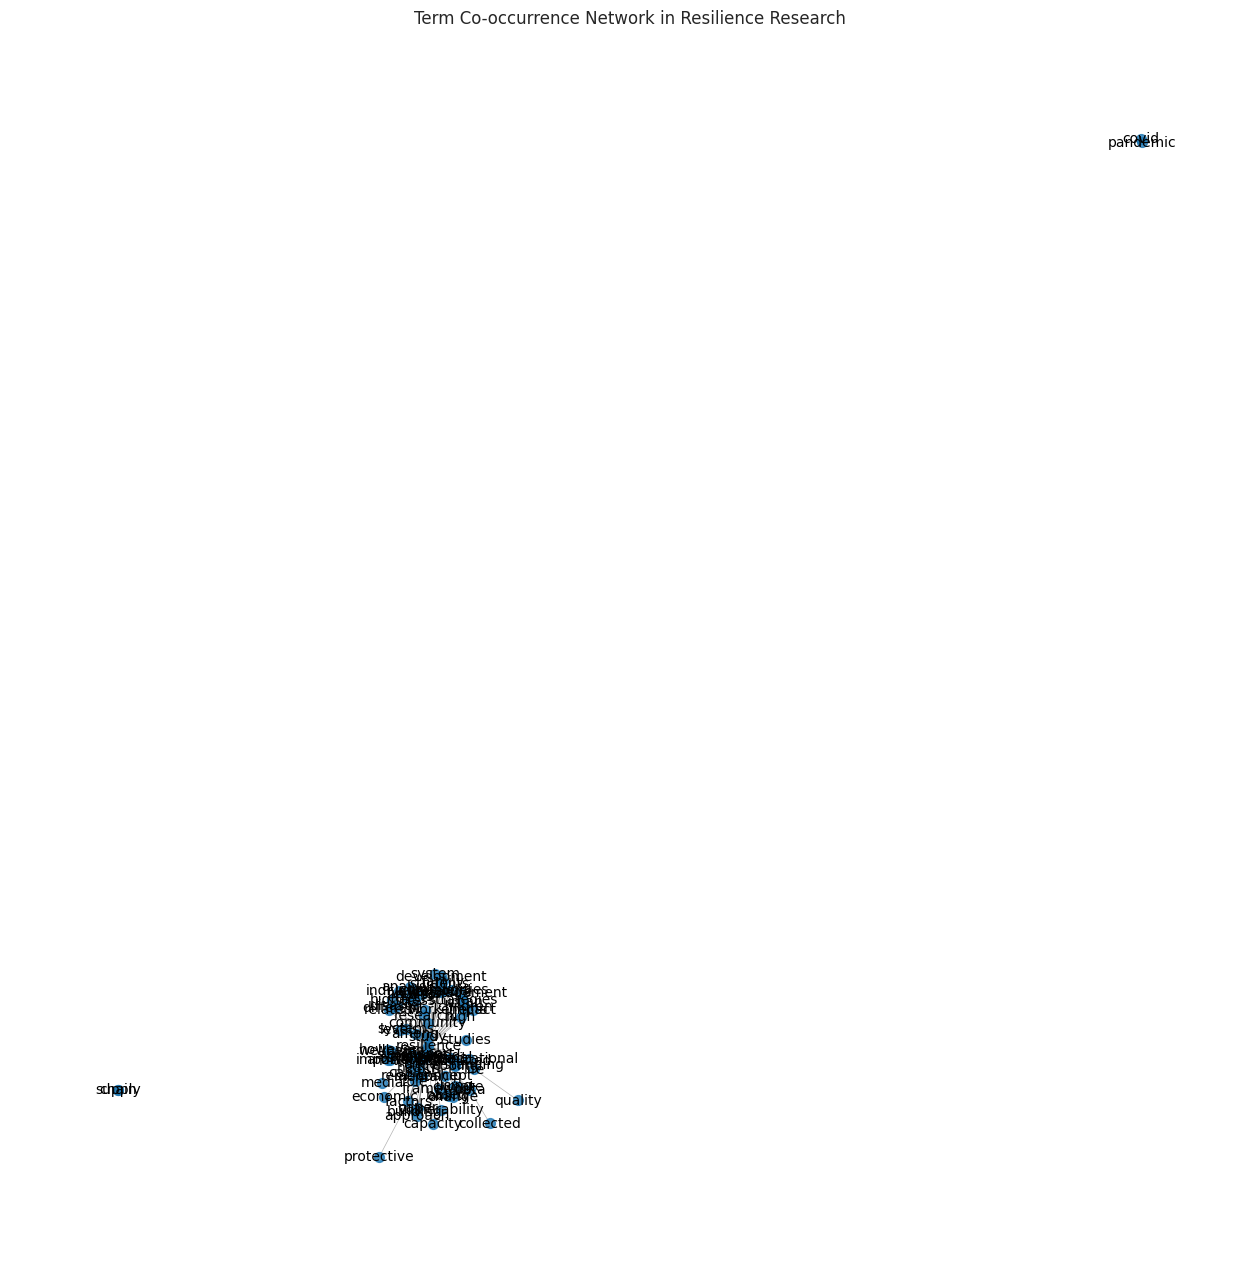

CPU times: user 33.9 s, sys: 1.72 s, total: 35.6 s
Wall time: 35.2 s


In [22]:
%%time
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Create co-occurrence matrix
def get_term_cooccurrence(tokens_list, window_size=5):
    cooccurrence = Counter()
    for tokens in tokens_list:
        for i in range(len(tokens)):
            window = tokens[max(0, i-window_size):min(len(tokens), i+window_size+1)]
            for pair in combinations(sorted(set(window)), 2):
                cooccurrence[pair] += 1
    return cooccurrence

# Get co-occurrences
cooccurrences = get_term_cooccurrence(authors_df['tokens'].tolist())

# Create network
G = nx.Graph()
for (term1, term2), weight in cooccurrences.most_common(100):  # Top 100 co-occurrences
    G.add_edge(term1, term2, weight=weight)

# Plot network
plt.figure(figsize=(16, 16))
pos = nx.spring_layout(G, seed=42)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(edge_weights)
edge_width = [0.1 + 5 * (w / max_weight) for w in edge_weights]

nx.draw_networkx_nodes(G, pos, node_size=50, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('Term Co-occurrence Network in Resilience Research')
plt.axis('off')
plt.savefig('cooccurrence_network.png', dpi=300)
plt.show()


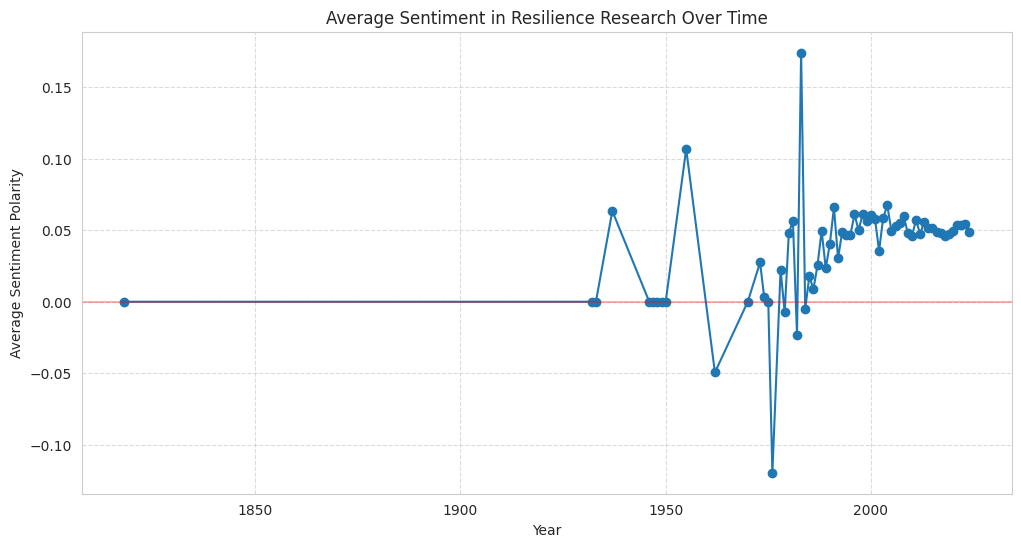

CPU times: user 15.3 s, sys: 189 ms, total: 15.5 s
Wall time: 15.2 s


In [23]:
%%time
from textblob import TextBlob

# Calculate sentiment polarity
authors_df['sentiment'] = authors_df['abstract'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity if isinstance(x, str) else 0
)

# Group by year
sentiment_by_year = authors_df.groupby('publication_year')['sentiment'].mean()

# Plot sentiment over time
plt.figure(figsize=(12, 6))
sentiment_by_year.plot(kind='line', marker='o')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Average Sentiment in Resilience Research Over Time')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Polarity')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('sentiment_analysis.png')
plt.show()

In [24]:
%%time
# Extract institution-specific abstracts
institution_abstracts = {}
for _, row in authors_df.iterrows():
    if isinstance(row.get('authors'), list):
        for author in row['authors']:
            if isinstance(author, dict) and 'institutions' in author:
                for inst in author.get('institutions', []):
                    if isinstance(inst, dict):
                        inst_name = inst.get('institution_name')
                        if inst_name and isinstance(row.get('abstract'), str):
                            if inst_name not in institution_abstracts:
                                institution_abstracts[inst_name] = []
                            institution_abstracts[inst_name].append(row['abstract'])

# Find top institutions by volume
top_institutions = sorted([(inst, len(abstracts)) for inst, abstracts in institution_abstracts.items()], 
                        key=lambda x: x[1], reverse=True)[:10]

# Analyze keywords for top institutions
institution_keywords = {}
for inst_name, count in top_institutions:
    if count >= 5:  # Only consider institutions with enough papers
        combined_text = ' '.join(institution_abstracts[inst_name])
        tokens = preprocess_text(combined_text)
        institution_keywords[inst_name] = Counter(tokens).most_common(10)

# Print distinctive keywords by institution
print("Distinctive keywords by institution:")
for inst, keywords in institution_keywords.items():
    print(f"\n{inst}:")
    for word, count in keywords:
        print(f"  {word}: {count}")

Distinctive keywords by institution:

Icahn School of Medicine at Mount Sinai:
  stress: 535
  resilience: 449
  depression: 265
  mice: 223
  social: 193
  brain: 161
  associated: 158
  resilient: 151
  females: 150
  ptsd: 143

Arizona State University:
  resilience: 744
  social: 268
  research: 156
  systems: 151
  network: 149
  infrastructure: 126
  study: 117
  health: 112
  urban: 111
  factors: 101

Stockholm University:
  resilience: 579
  water: 305
  systems: 202
  change: 176
  socialecological: 151
  management: 134
  system: 125
  global: 116
  ecosystem: 110
  food: 109

Harvard University:
  resilience: 474
  health: 182
  social: 173
  amyloid: 161
  alzheimers: 156
  risk: 155
  study: 145
  army: 124
  individuals: 118
  cases: 117

University of Washington:
  resilience: 875
  cancer: 193
  social: 188
  outcomes: 184
  study: 176
  health: 160
  associated: 156
  factors: 148
  among: 145
  depression: 129

Wageningen University & Research:
  resilience: 1095
  s

Terms most similar to 'resilience':
resiliency: 0.6953
adaptation: 0.4721
resiliencethe: 0.4593
wellbeing: 0.4543
strengths: 0.4501
multidimensional: 0.4176
adaptability: 0.4122
resilient: 0.4048
theoretical: 0.4041
attributes: 0.3979
operationalized: 0.3973
scres: 0.3855
social: 0.3790
organizational: 0.3775
capital: 0.3748
overall: 0.3661
also: 0.3656
constructs: 0.3654
selfcompassion: 0.3651
conceptualization: 0.3637
Number of word vectors: 47


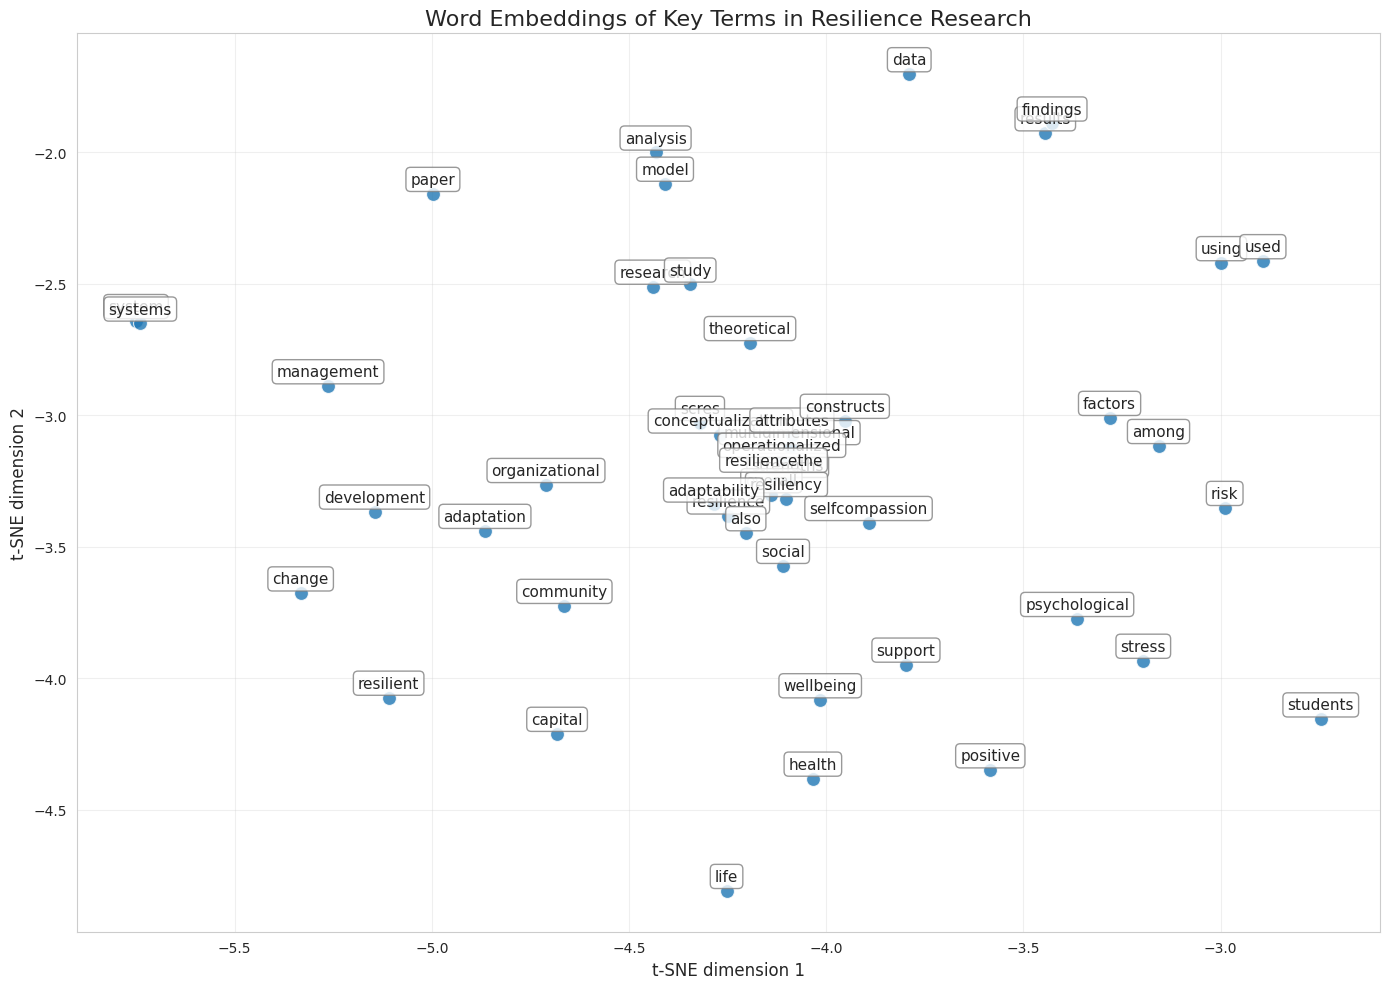

<ipython-input-25-a32dbf43dab9>:122: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


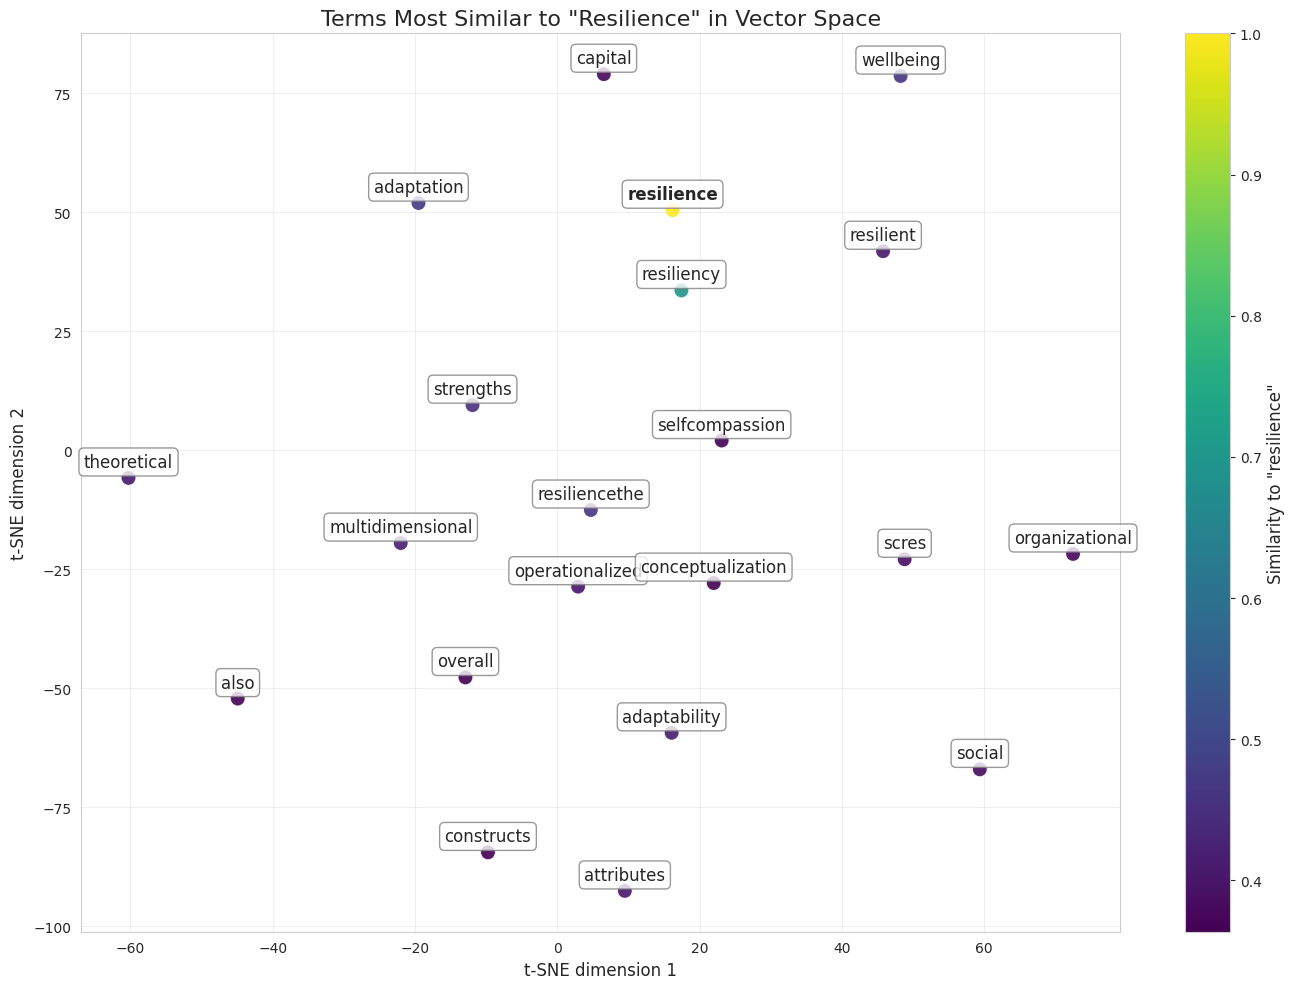

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import seaborn as sns

# Train Word2Vec model
w2v_model = Word2Vec(authors_df['tokens'].tolist(), vector_size=100, window=5, min_count=5, workers=4)
w2v_model.train(authors_df['tokens'].tolist(), total_examples=len(authors_df), epochs=10)

# Get vector for resilience and find similar terms
resilience_vector = w2v_model.wv['resilience']
similar_terms = w2v_model.wv.most_similar('resilience', topn=20)
print("Terms most similar to 'resilience':")
for term, similarity in similar_terms:
    print(f"{term}: {similarity:.4f}")

# Visualize word embeddings
def plot_word_embeddings(model, words):
    # Extract word vectors
    word_vectors = np.array([model.wv[w] for w in words if w in model.wv])
    words = [w for w in words if w in model.wv]
    n_samples = len(word_vectors)
    print(f"Number of word vectors: {n_samples}")
    
    if n_samples < 5:
        print("Not enough word vectors to perform t-SNE. Need at least 5.")
        return
    
    # Reduce dimensionality with t-SNE
    # Set perplexity to min(30, n_samples - 1) to avoid the error
    perplexity = min(30, n_samples - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    transformed = tsne.fit_transform(word_vectors)
    
    # Plot
    plt.figure(figsize=(14, 10))
    
    # Create scatter plot
    scatter = sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], s=100, alpha=0.8)
    
    # Add labels with better positioning and formatting
    for i, word in enumerate(words):
        plt.annotate(
            word, 
            (transformed[i, 0], transformed[i, 1]),
            fontsize=11,
            ha='center',
            va='bottom', 
            xytext=(0, 5),
            textcoords='offset points',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )
    
    # Add title and styling
    plt.title('Word Embeddings of Key Terms in Resilience Research', fontsize=16)
    plt.xlabel('t-SNE dimension 1', fontsize=12)
    plt.ylabel('t-SNE dimension 2', fontsize=12)
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('word_embeddings.png', dpi=300, bbox_inches='tight')
    plt.show()

# Expand visualization to include both common terms and terms similar to resilience
# Get top terms from most_common_terms
key_words = [word for word, count in most_common_terms[:50] if word in w2v_model.wv]

# Add terms similar to 'resilience'
similar_words = [word for word, _ in similar_terms]
key_words = list(set(key_words + similar_words))

# Create a more comprehensive visualization
plot_word_embeddings(w2v_model, key_words)

# Create a focused visualization showing just the terms similar to resilience
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

# Get vectors for terms similar to resilience
resilience_terms = ['resilience'] + [term for term, _ in similar_terms]
resilience_vectors = np.array([w2v_model.wv[w] for w in resilience_terms if w in w2v_model.wv])
resilience_terms = [w for w in resilience_terms if w in w2v_model.wv]

# Use a smaller perplexity for this smaller dataset
perplexity = min(5, len(resilience_vectors) - 1)
tsne_resilience = TSNE(n_components=2, random_state=42, perplexity=perplexity)
transformed_resilience = tsne_resilience.fit_transform(resilience_vectors)

# Create a gradient of colors based on similarity to resilience
similarities = [1.0] + [sim for _, sim in similar_terms if w2v_model.wv.get_vector(term).any()]
cmap = plt.cm.viridis

# Plot with colored points based on similarity
plt.scatter(
    transformed_resilience[:, 0], 
    transformed_resilience[:, 1], 
    c=similarities, 
    cmap=cmap, 
    s=120, 
    alpha=0.9,
    edgecolors='white'
)

# Add labels
for i, term in enumerate(resilience_terms):
    plt.annotate(
        term, 
        (transformed_resilience[i, 0], transformed_resilience[i, 1]),
        fontsize=12,
        fontweight='bold' if term == 'resilience' else 'normal',
        ha='center',
        va='bottom', 
        xytext=(0, 5),
        textcoords='offset points',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )

# Add a colorbar to show similarity scale
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(similarities)
cbar = plt.colorbar(sm)
cbar.set_label('Similarity to "resilience"', fontsize=12)

plt.title('Terms Most Similar to "Resilience" in Vector Space', fontsize=16)
plt.xlabel('t-SNE dimension 1', fontsize=12)
plt.ylabel('t-SNE dimension 2', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('resilience_similar_terms.png', dpi=300, bbox_inches='tight')
plt.show()